In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();

# Base

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [3]:
reload(librun)
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-00cc782b-db8d-496c-a5f5-5647e3576743.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
for plots, clfs in zip(results_plots, classifiers):
    for i, clfs_ in enumerate(clfs):
        if len(clfs_) != 100:
            print(f"{plots[0].serialize()}_{i}.zip")

In [5]:
reload(libstop)
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

In [6]:
from itertools import groupby
def f():
    table = np.ones((len(stop_results), len(next(iter(stop_results.values())))))
    for i, (dataset, results) in enumerate(stop_results.items()):
        for j, (method, runs) in enumerate(results.items()):
            percent = np.count_nonzero([run[0] for run in runs])/len(runs)
            table[i][j] = percent
            
    skip = [(table[:,i]!=1.0).any() for i in range(len(table[0]))]
    table = table[:,skip]
    return table, skip
    
t, skip = f()
print(tabulate(
    t,
    showindex=stop_results.keys(), 
    headers=["dataset", *np.array(list(stop_results[list(stop_results.keys())[0]].keys()))[skip]], floatfmt=".0%", tablefmt='latex'
))

\begin{tabular}{lrrr}
\hline
 dataset      &   SC\_entropy\_mcs &   EVM &   stabilizing\_predictions \\
\hline
 rcv1         &               0\% &    0\% &                      100\% \\
 webkb        &               0\% &  100\% &                      100\% \\
 spamassassin &               0\% &   90\% &                      100\% \\
 avila        &               0\% &  100\% &                       70\% \\
 smartphone   &               0\% &  100\% &                      100\% \\
 swarm        &               0\% &    0\% &                      100\% \\
 sensorless   &               0\% &  100\% &                       90\% \\
 splice       &               0\% &   90\% &                      100\% \\
 anuran       &               0\% &  100\% &                      100\% \\
\hline
\end{tabular}


In [6]:
def plot_stop(plots, classifiers, stop_conditions, stop_results, scale='linear', figsize=(26, 4)):
    import matplotlib.pyplot as plt; from libstop import first_acc, no_ahead_tvregdiff
    figaxes = librun.plot(plots, ret=True, sort=False, extra=2, scale=scale, figsize=figsize)
    for i, (fig, ax) in enumerate(figaxes):
        clfs = classifiers[i]
        metrics = plots[i][1]
        
        for j, clfs_ in enumerate(clfs):
            if len(clfs_) < 100:
                raise Exception(f'short classifier file: {plots[i][0].serialize()}_{j}.zip\nIt has length {len(clfs_)} when it should have length 100')
        
        if plots[i][0].dataset_mutator_name != 'none':
            scores = __get_passive_scores(plots[i][0], range(len(plots[i][1])))
            for ax, score in zip(ax, scores):
                ax.axhline(score, color='tab:gray', ls='--')
            
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        accs = [first_acc(clfs_)[1] for clfs_ in clfs]
        accx = first_acc(clfs[0])[0]
                
        acc_median = np.median(accs, axis=0)
        acc_stderr = np.std(accs, axis=0)
        
        ax[-1].plot(metrics[0].x[:acc_median.shape[0]], acc_median)
        ax[-1].set_title("First classifier accuracy")
        
        ax1 = ax[-1].twinx()
        #ax1.axhline(0, ls='--', color='grey', alpha=0.8)
        #ax1.plot(metrics[0].x[:acc_median.shape[0]], no_ahead_tvregdiff(acc_median, 1, 1e-1, plotflag=False, diagflag=False), ls='--')
        
        #ax1.plot(metrics[0].x, 1/metrics[0].x, color='purple')
        ax1.plot(metrics[0].x[:acc_median.shape[0]], acc_median-metrics[0].x[:acc_median.shape[0]], color='green')
        
        # Fit exponential
        def func(x, A, B, C, D):
                return A*np.log(B*(x-D))-C*x
            
        fit = curve_fit(func, x, y, [1/10, 4, 0.0000001, 10])
        
        ax[0].plot(func(metrics[0].x, *fit[0]), color='red')

        if 'expected_error_min' in metrics[0]:
            ax[-2].plot(metrics[0].x, metrics[0].expected_error_min, ls='--')
            ax[-2].set_title("expected_error_min")

            ax2 = ax[-2].twinx()
            ax2.axhline(0, ls='--', color='grey', alpha=0.8)
            ee_first = no_ahead_tvregdiff(metrics[0].expected_error_min[1:], 1, 1e2, plotflag=False, diagflag=False)
            ee_second = no_ahead_tvregdiff(ee_first[2:], 1, 15, plotflag=False, diagflag=False)
            ax2.plot(metrics[0].x[1:], ee_first/np.max(np.abs(ee_first[2:])), label='1st')
            ax2.plot(metrics[0].x[3:], ee_second/np.max(np.abs(ee_second[2:])), label='2nd')
            ax2.legend()

            #align_yaxis(ax[-2], ax2)

        for ii, a in enumerate(ax):        
            for iii, (name, cond) in enumerate(stop_conditions.items()):
                stops = stop_results[plots[i][0].dataset_name][name]
                for iiii, stop in enumerate(stops):
                    if stop[0] is not None:
                        #print(stop)
                        a.axvline(stop[0], label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])
                        break

        fig.legend()
        fig.tight_layout()

NameError: name 'curve_fit' is not defined

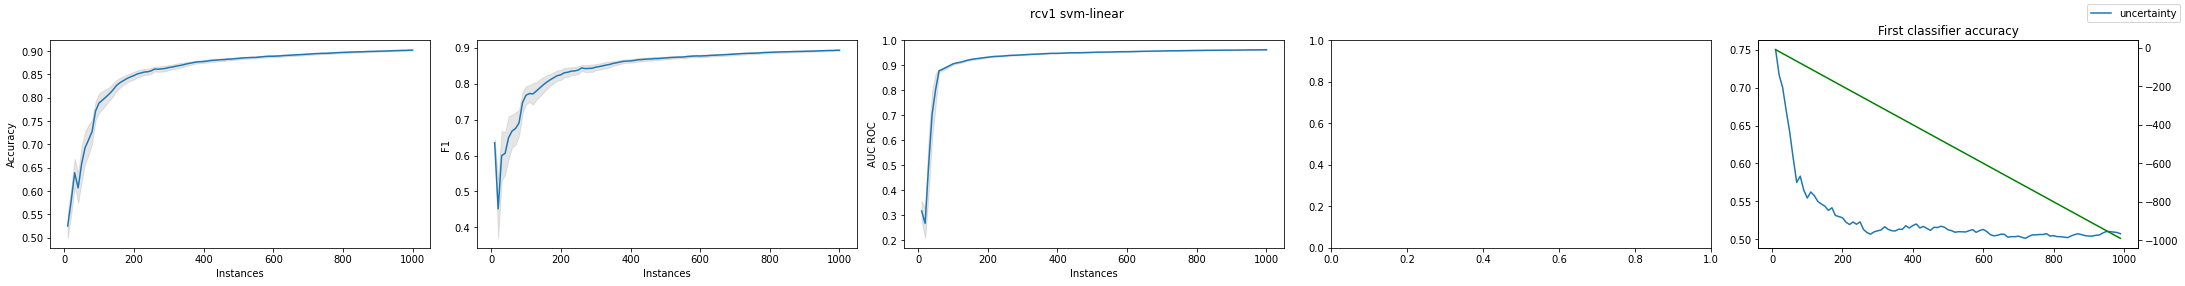

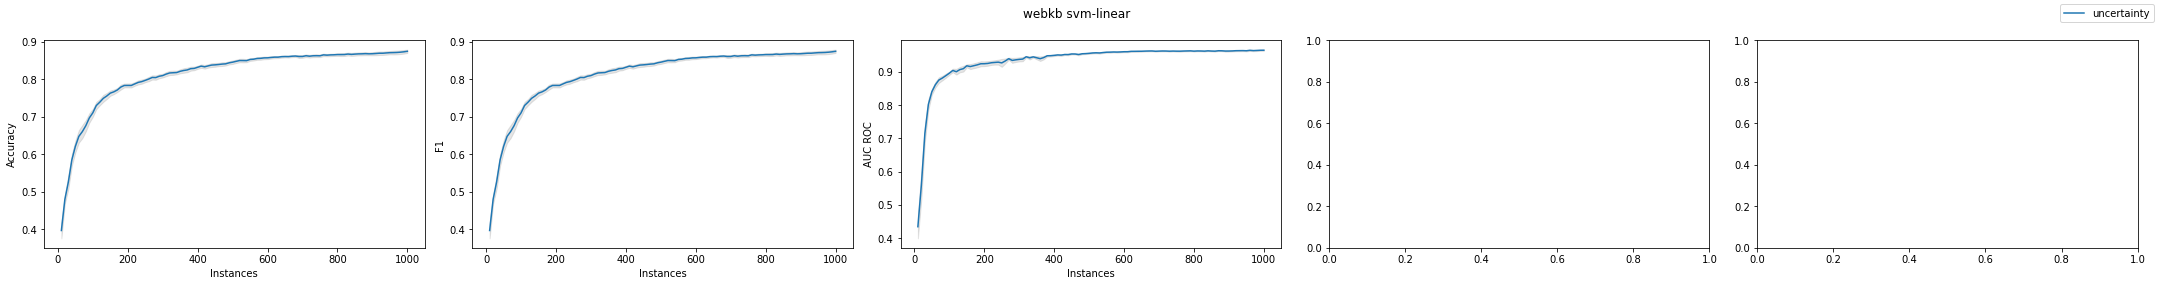

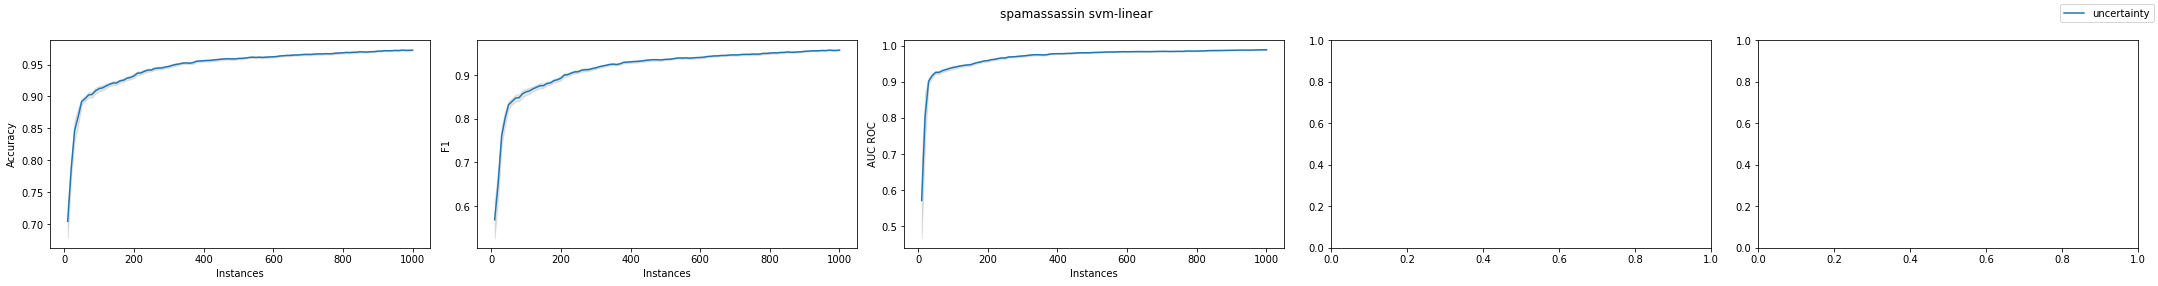

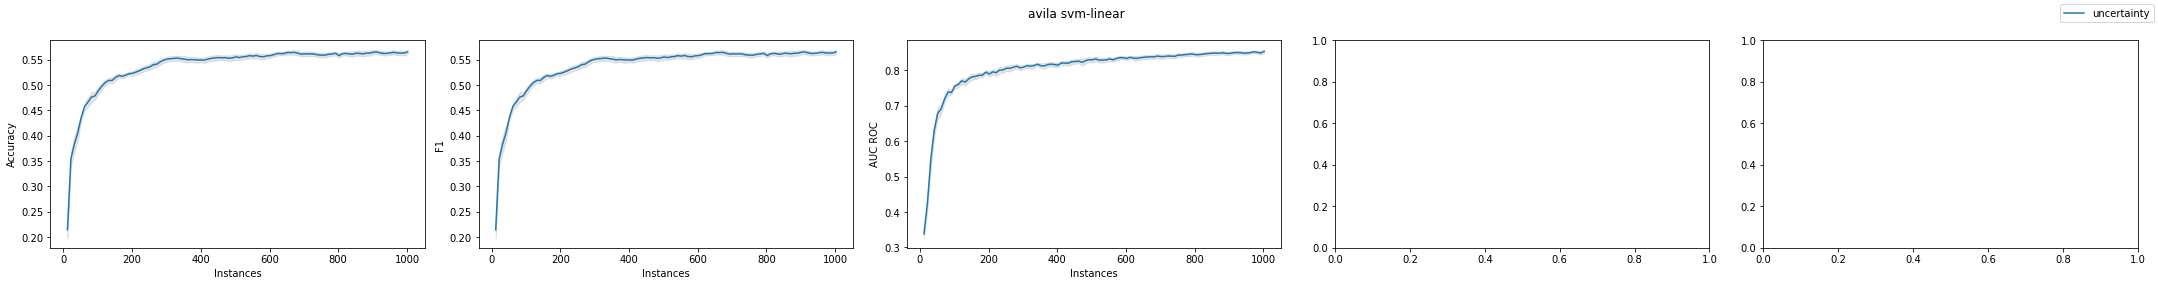

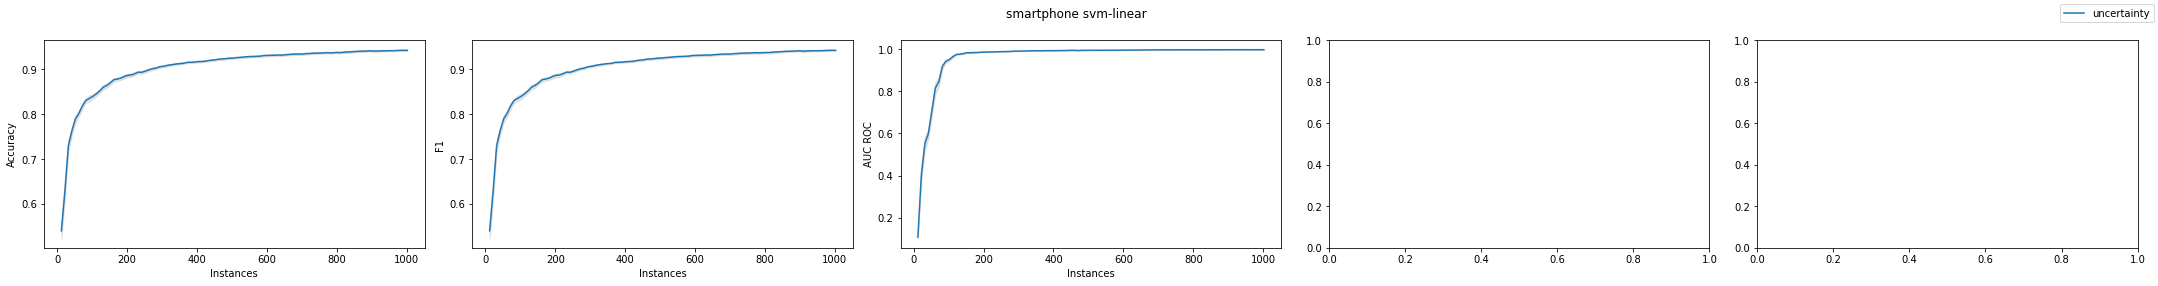

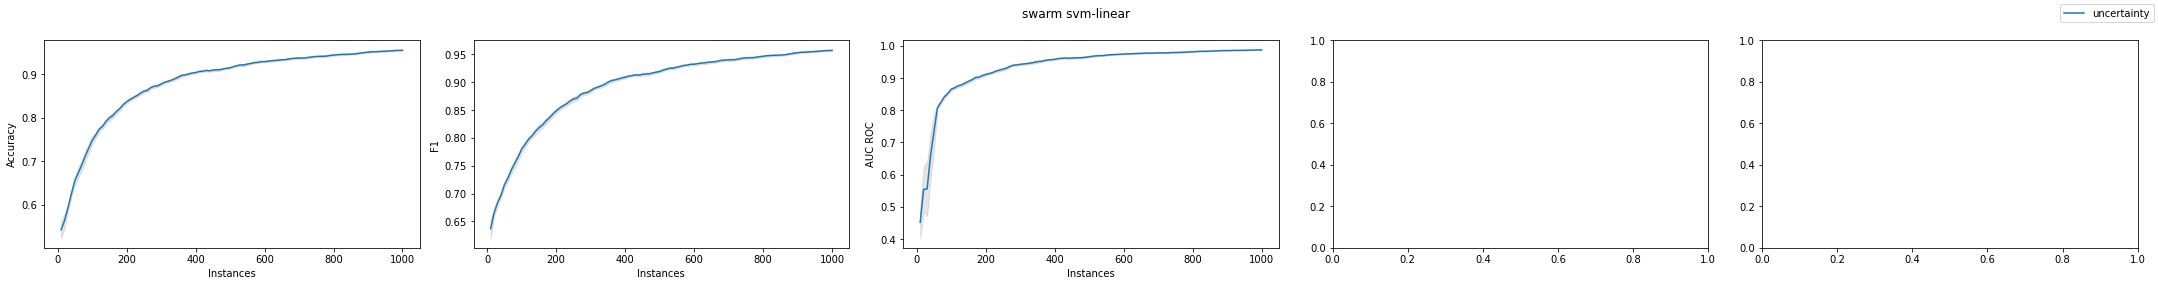

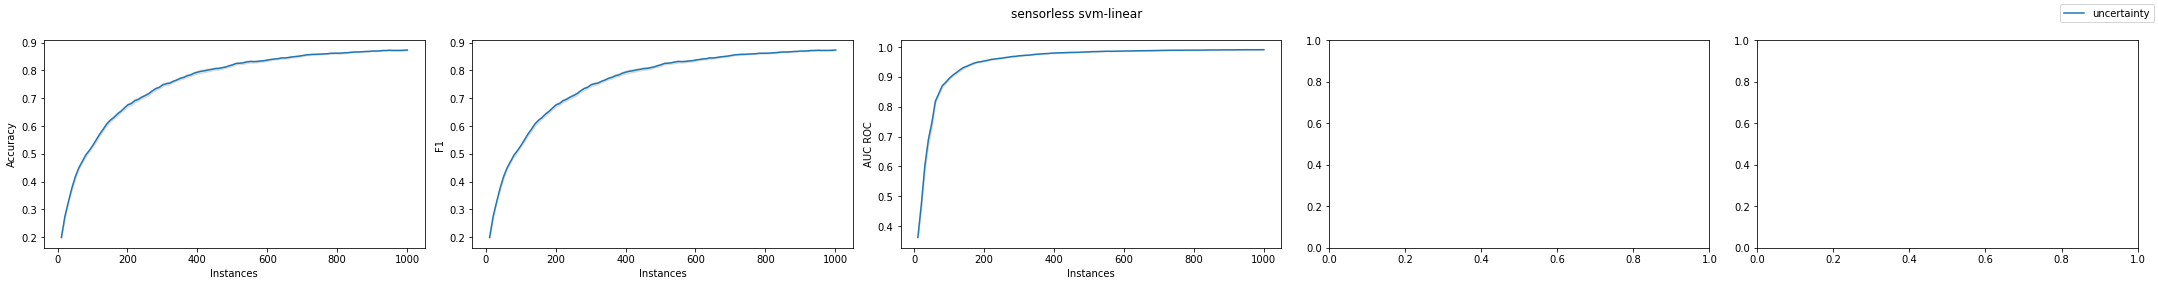

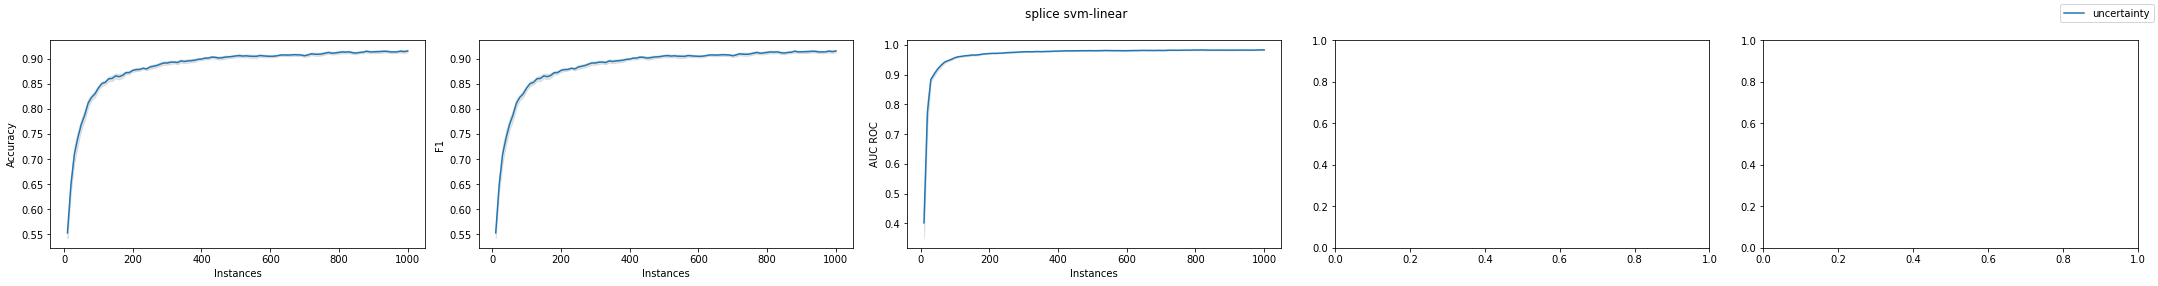

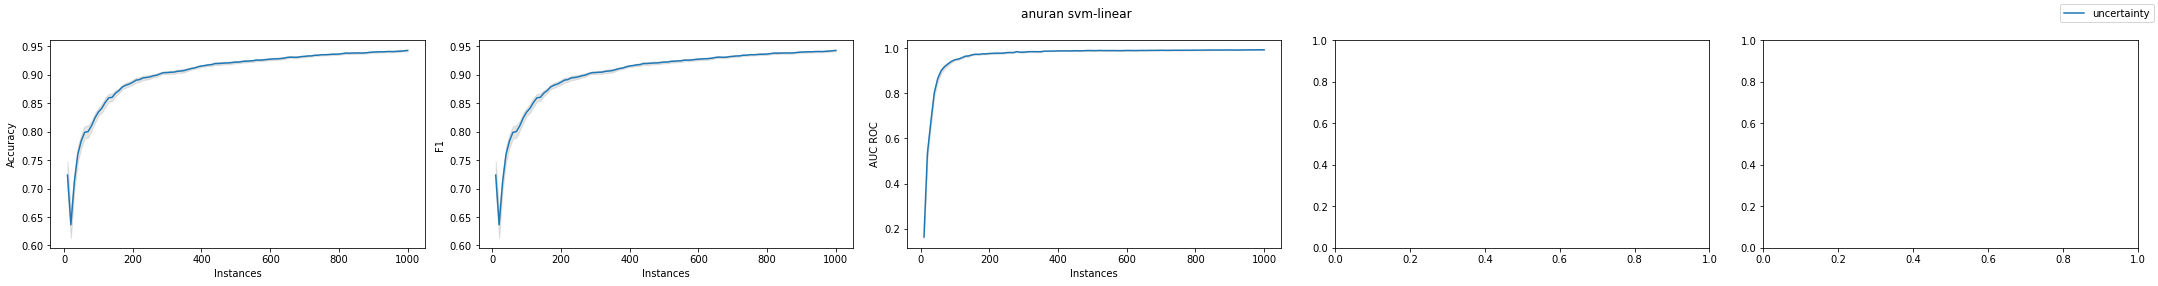

In [7]:
plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4), scale='linear') # scale='logit'

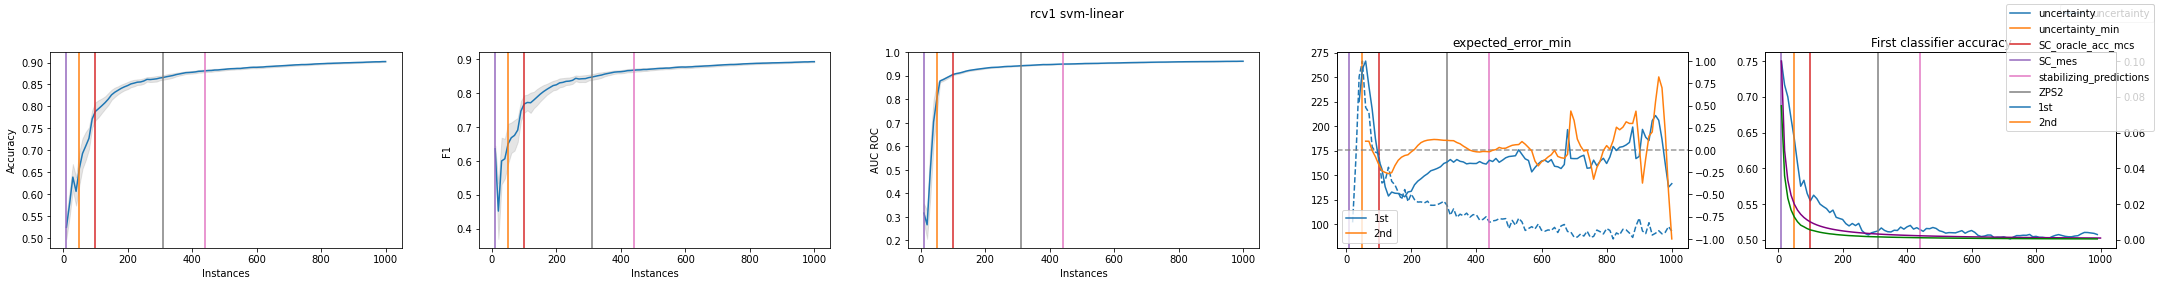

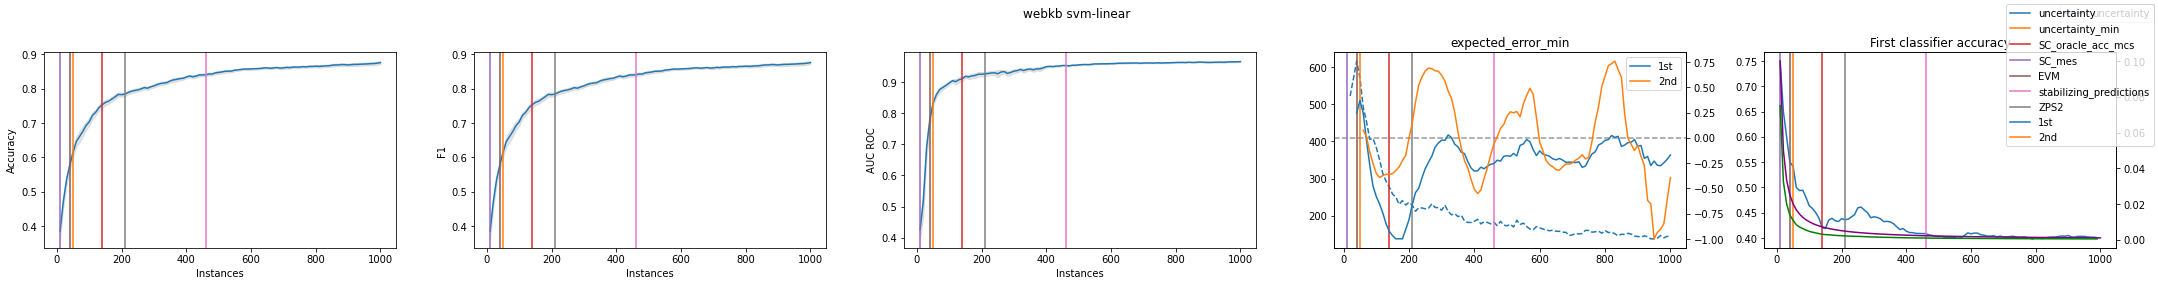

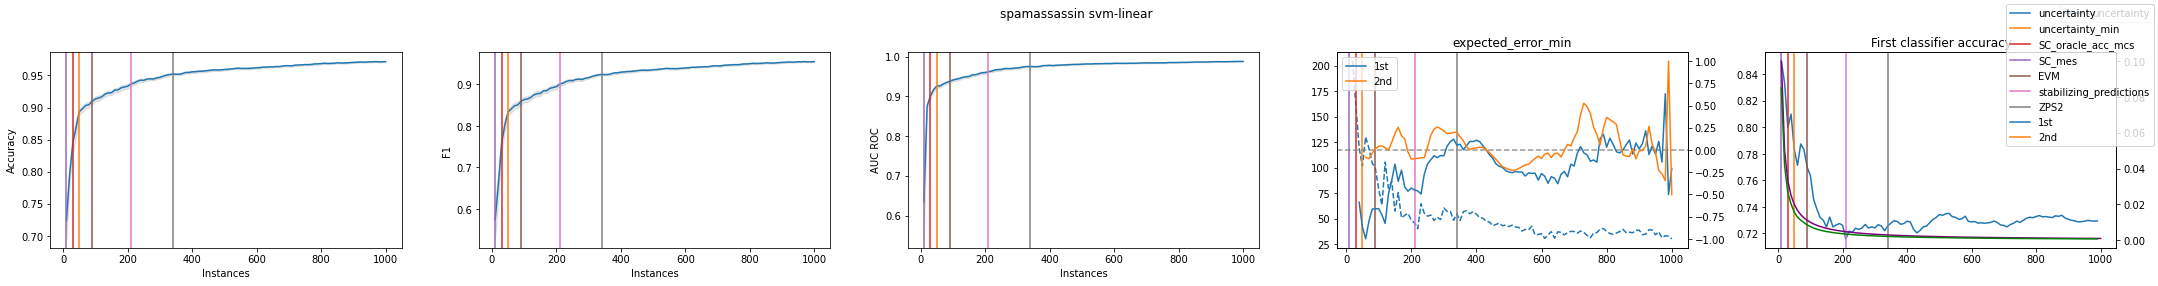

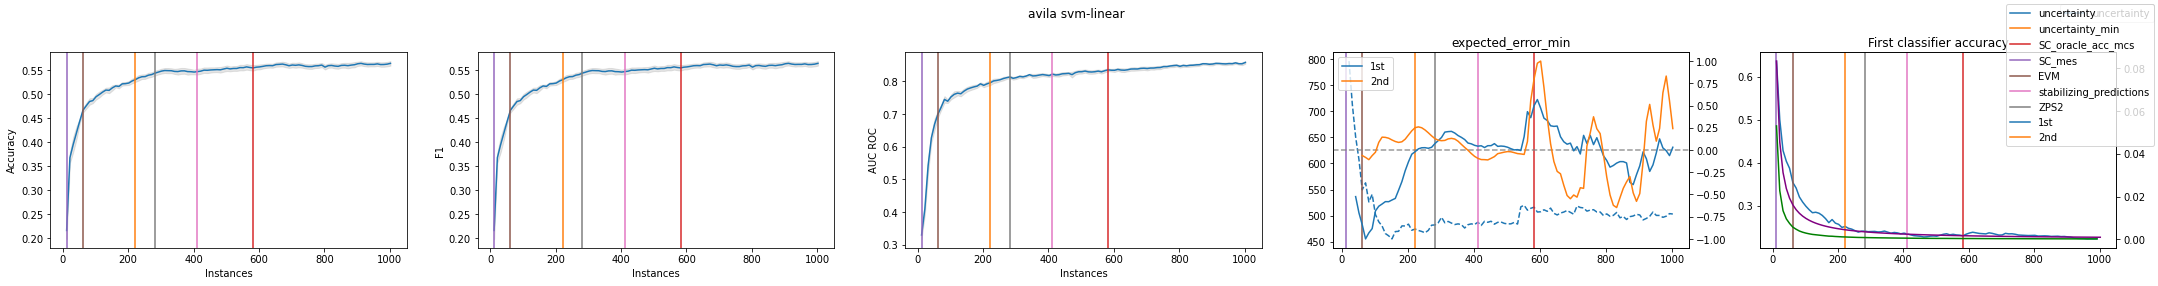

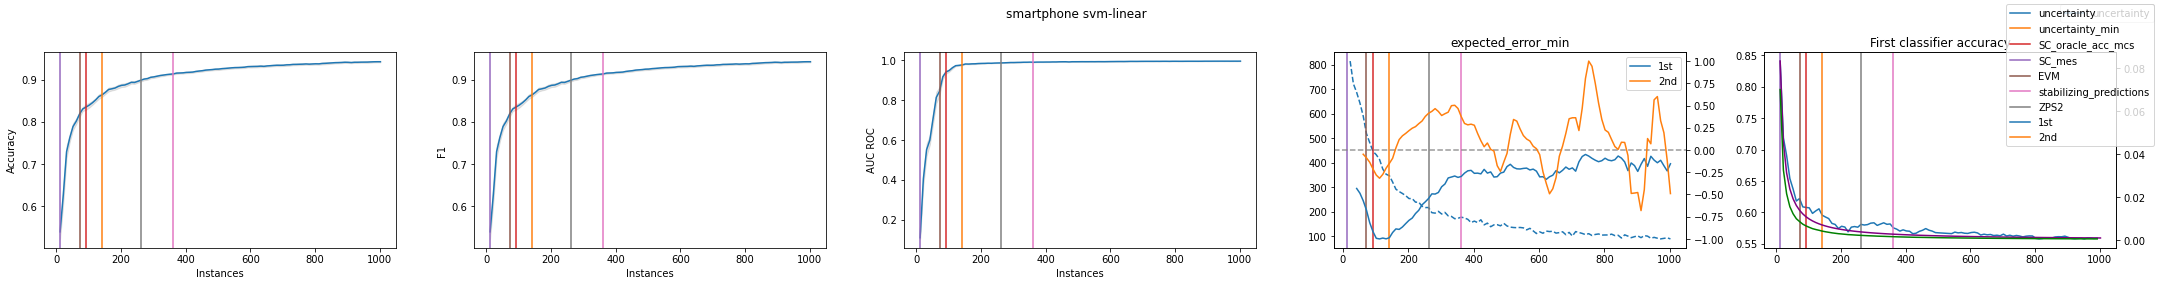

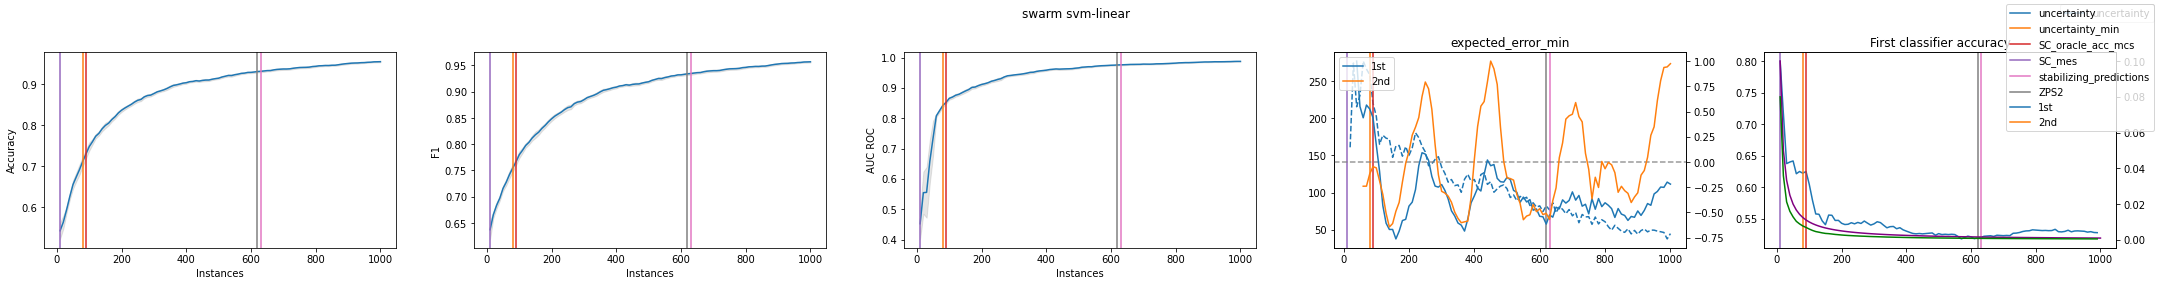

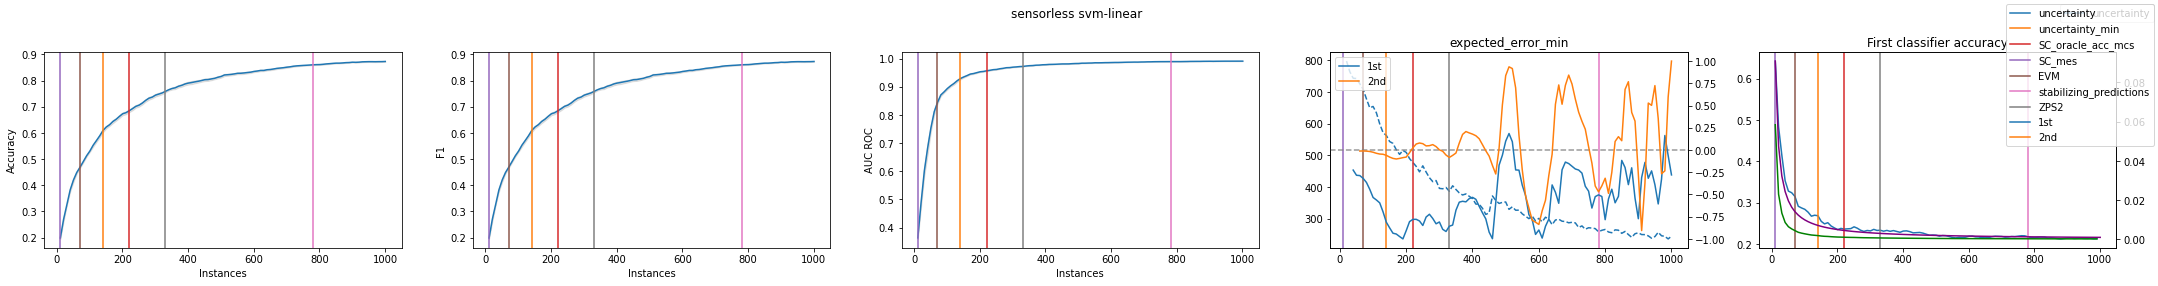

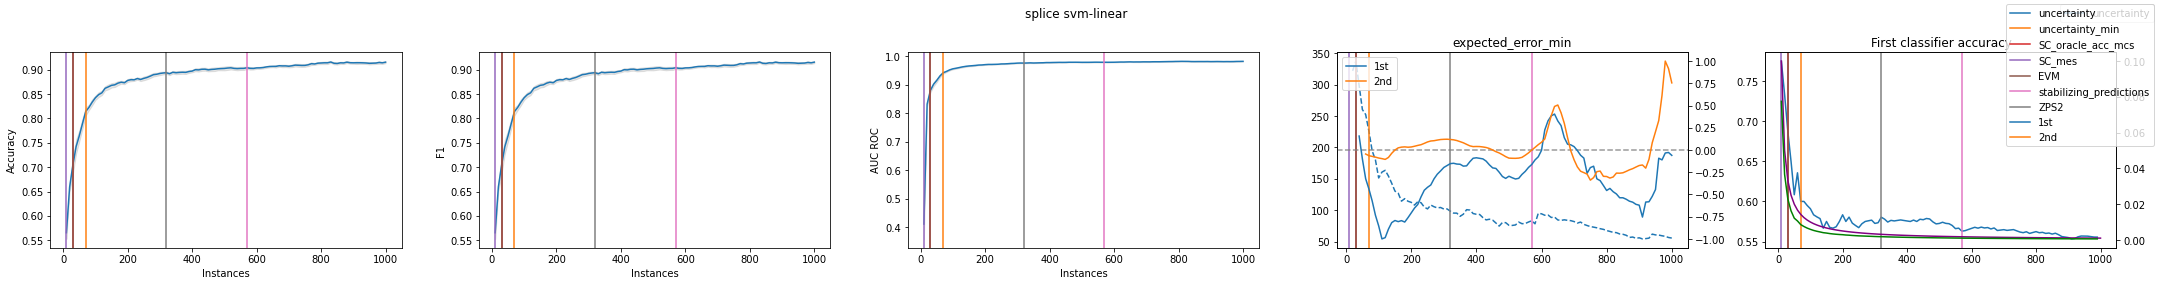

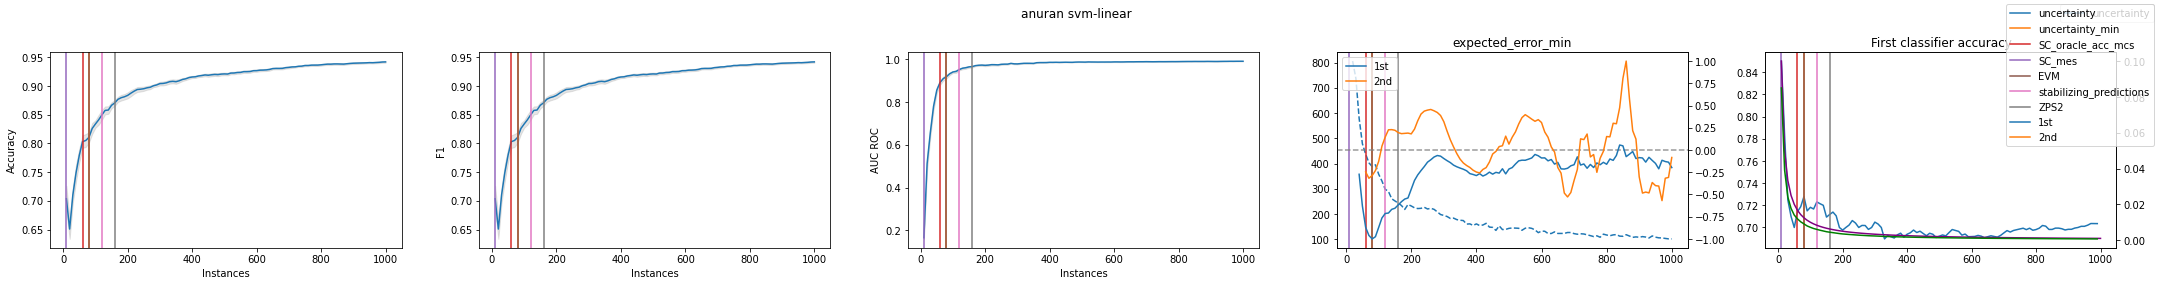

In [20]:
plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4), scale='linear') # scale='logit'

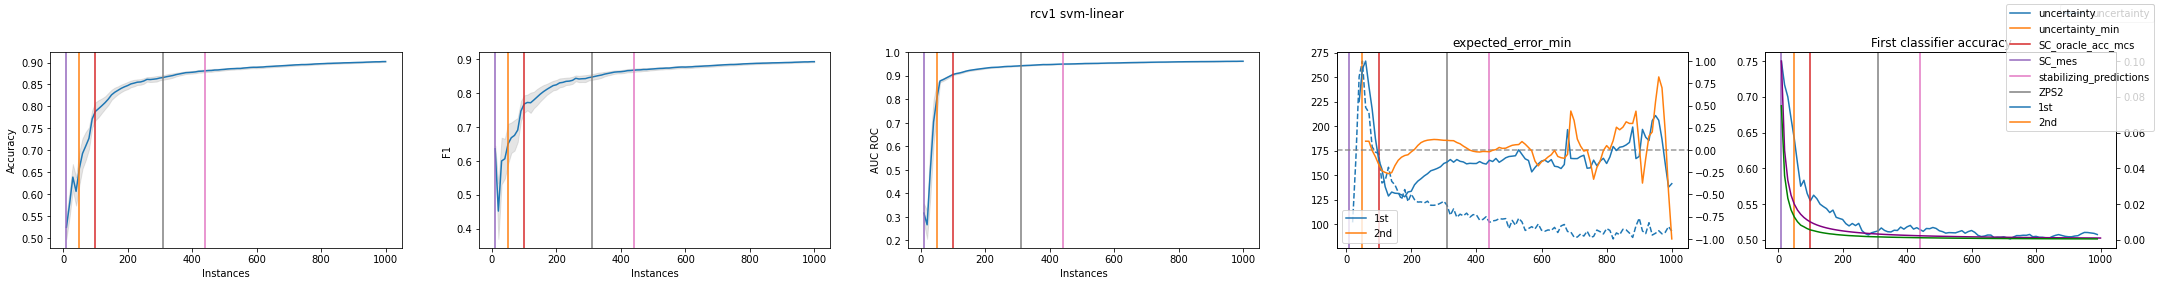

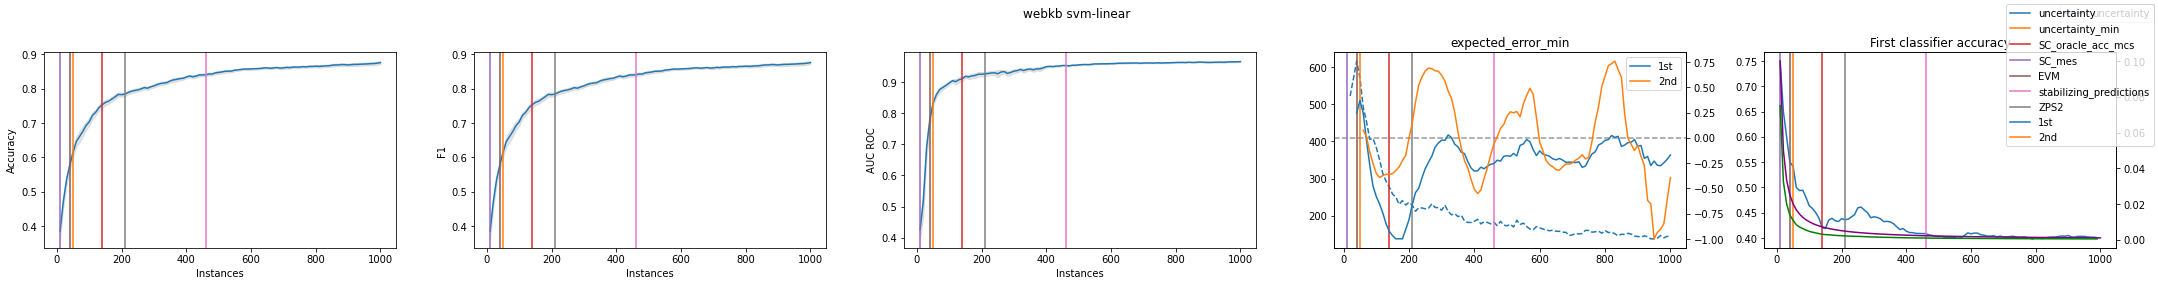

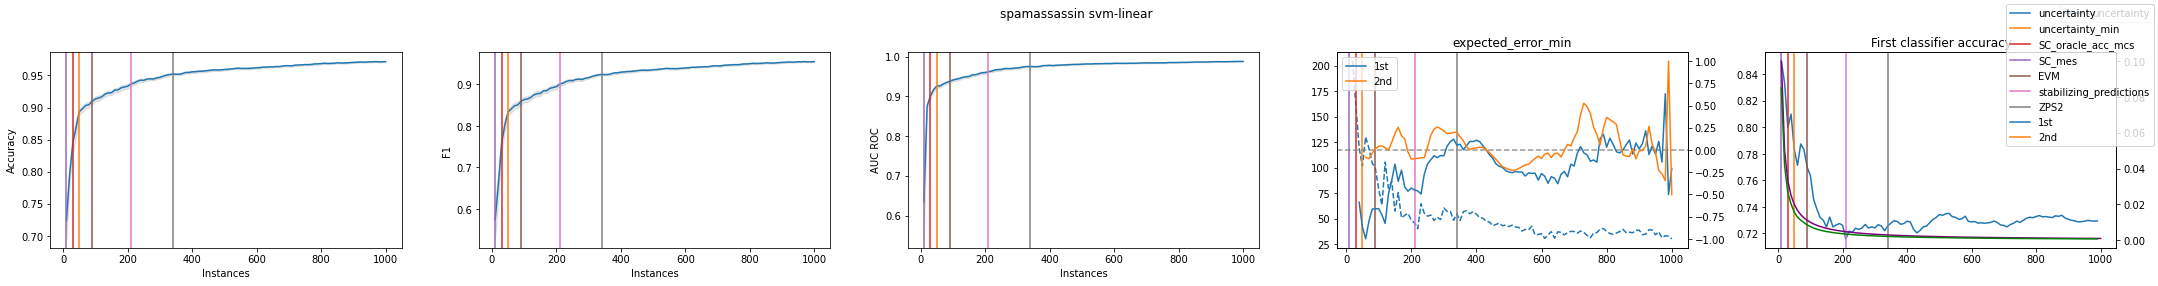

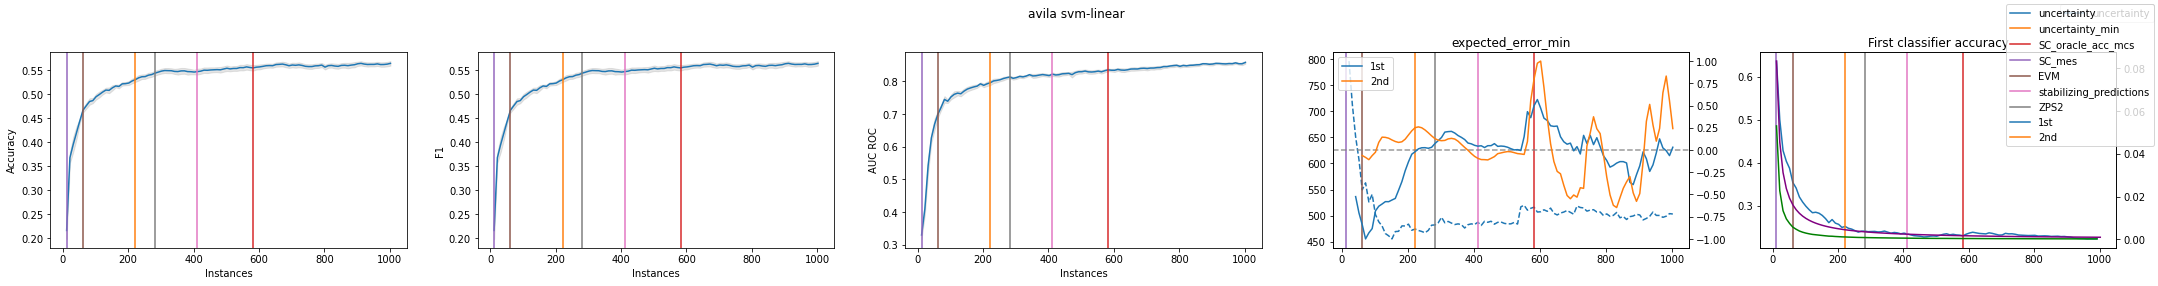

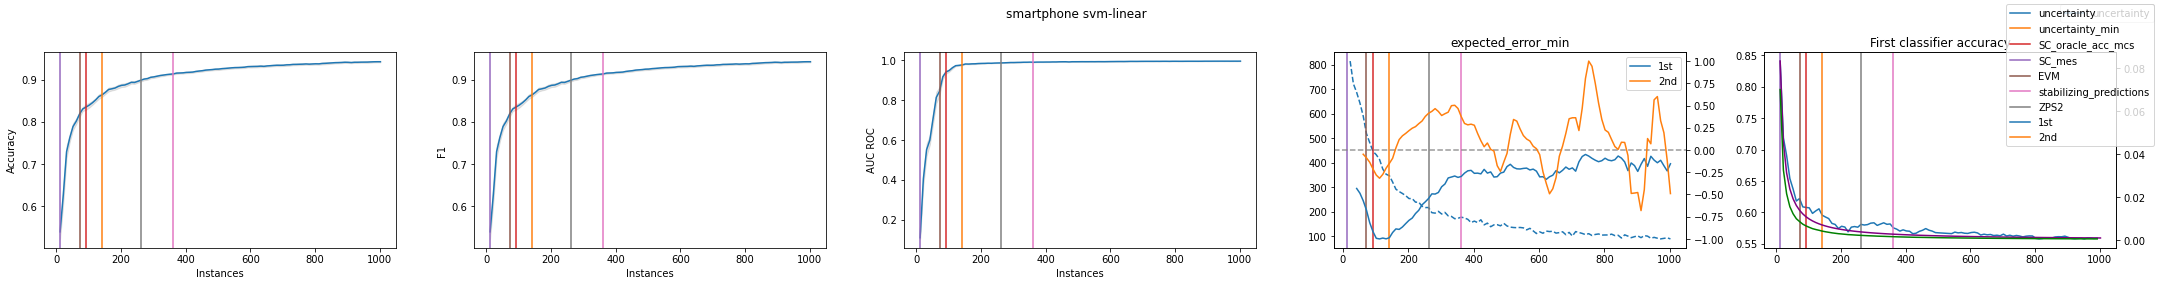

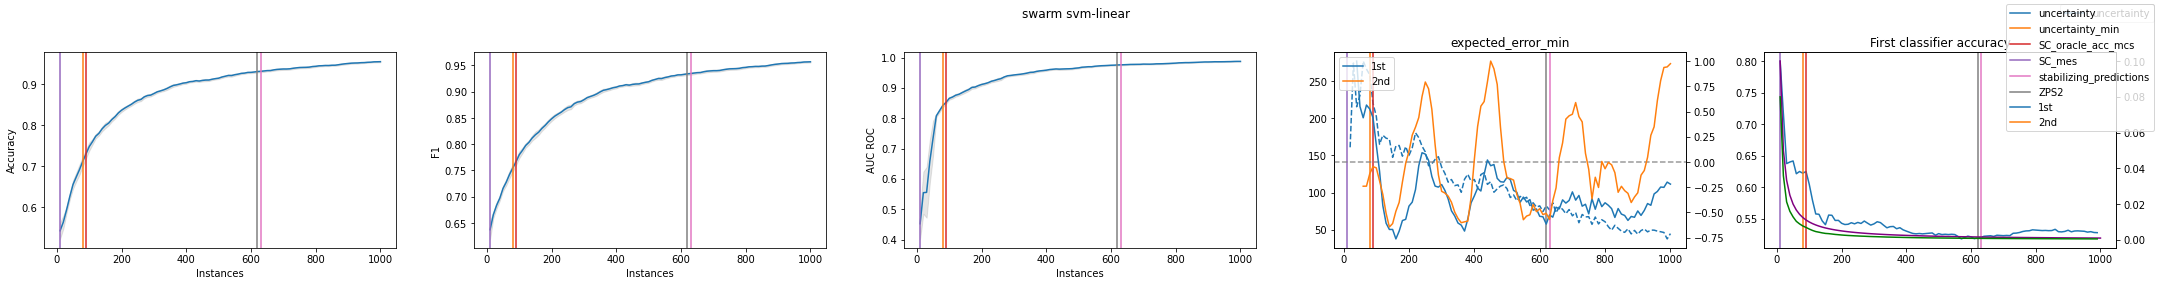

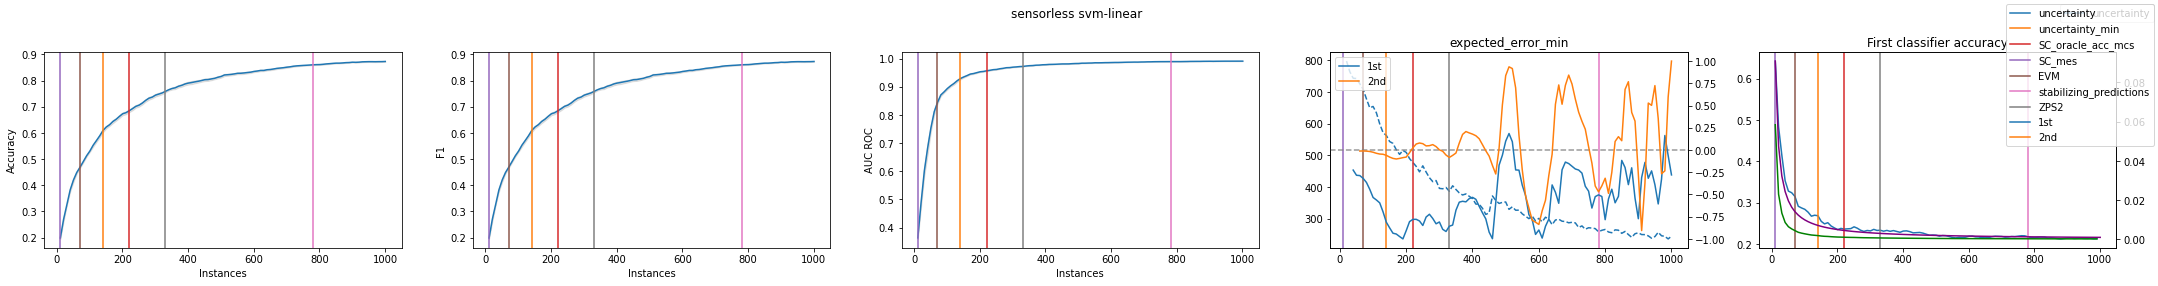

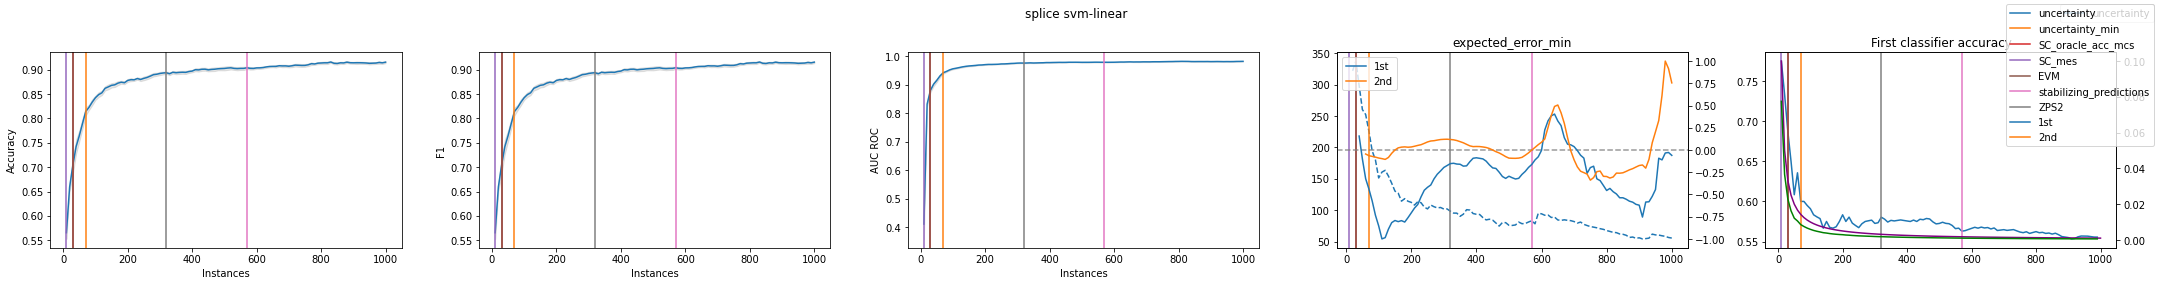

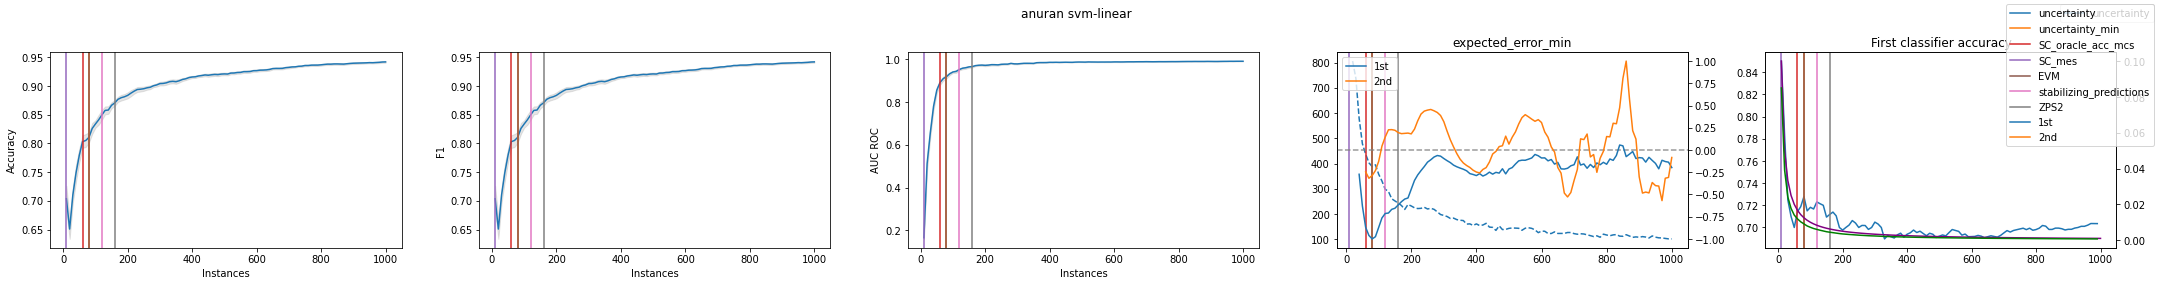

In [21]:
plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4), scale='linear') # scale='logit'

### Without Averaging

In [12]:
from autorank import plot_stats

C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


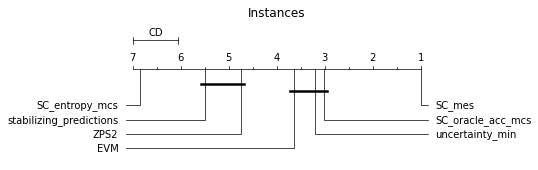

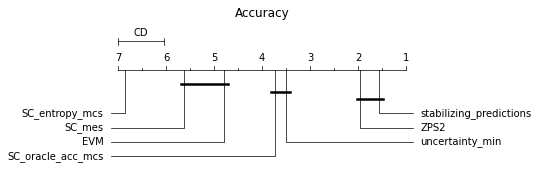

In [26]:
reload(libstop); from libstop import rank_stop_conds; import matplotlib.pyplot as plt
#fig, axes = plt.subplots(1,2, figsize=(16,3))
ax1 = rank_stop_conds(stop_results, results_plots, 'instances', )#ax=axes[0])
ax2 = rank_stop_conds(stop_results, results_plots, 'accuracy_score', );#ax=axes[1]);
ax1.figure.savefig('figures/base_instances.png', bbox_inches='tight')
ax2.figure.savefig('figures/base_accuracy.png', bbox_inches='tight')

### With Averaging

C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\autorank\_util.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


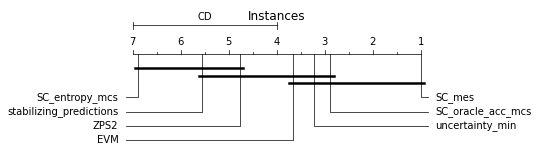

In [10]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'instances', average=True);

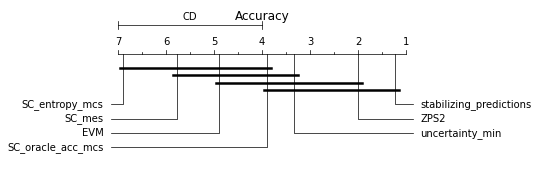

In [11]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'accuracy_score', average=True);

# Noise (10%)

In [10]:
def noise():
    pass
matrix = {
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        #("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "noise10": partial(noise, amount=1e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}


In [5]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-4326f8ec-7bdc-469e-8a8f-a3c3e0834943.json']


Experiment:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

In [ ]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Noise (20%)

In [59]:
def noise():
    pass
matrix = {
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        #("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "noise10": partial(noise, amount=2e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}


In [60]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

Experiment:   0%|          | 0/7 [00:00<?, ?it/s]

In [61]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

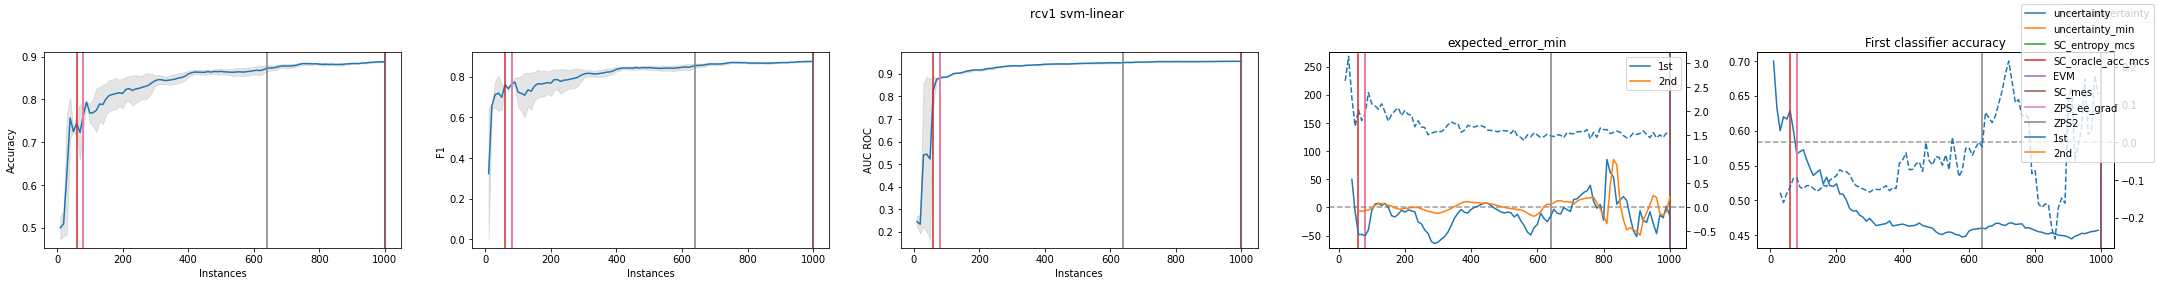

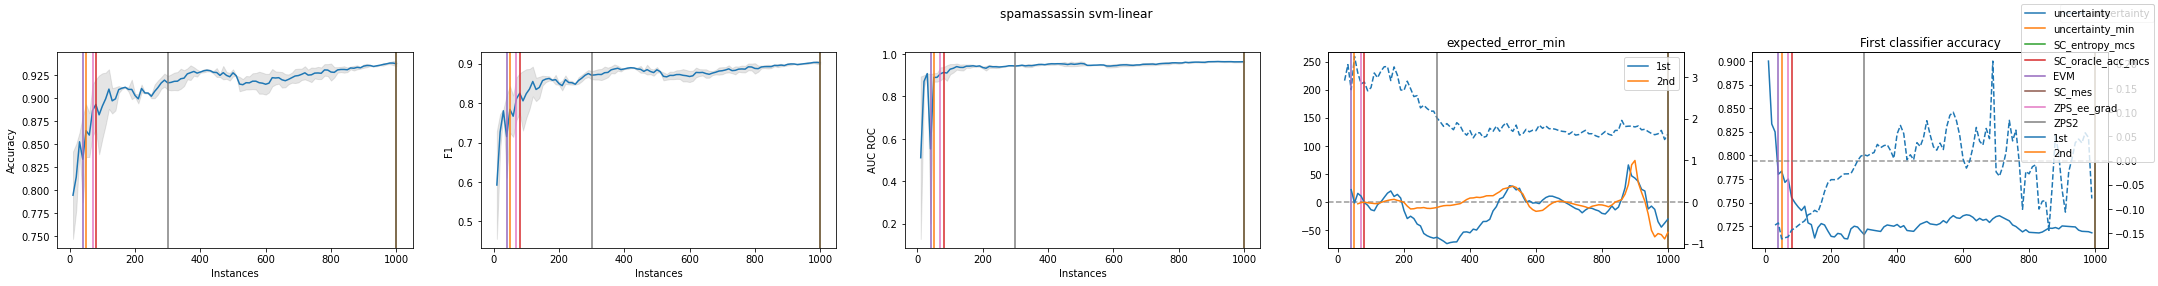

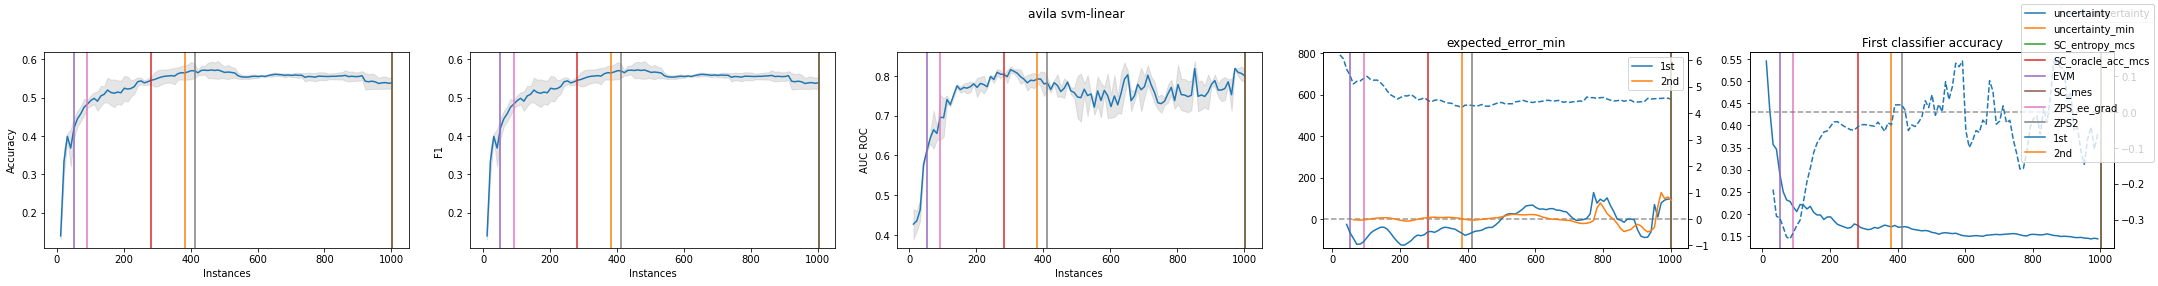

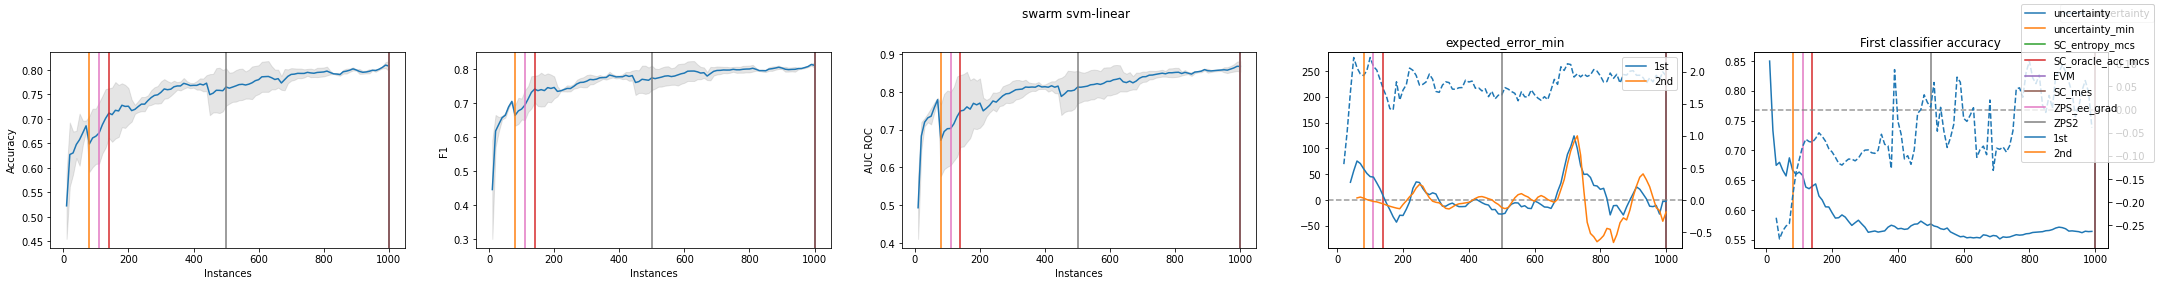

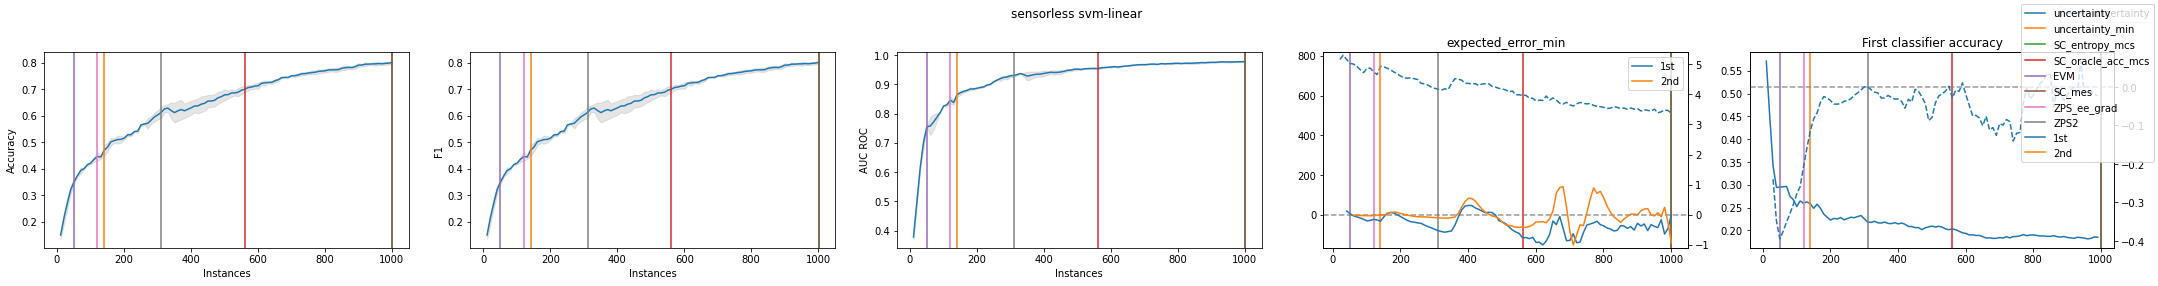

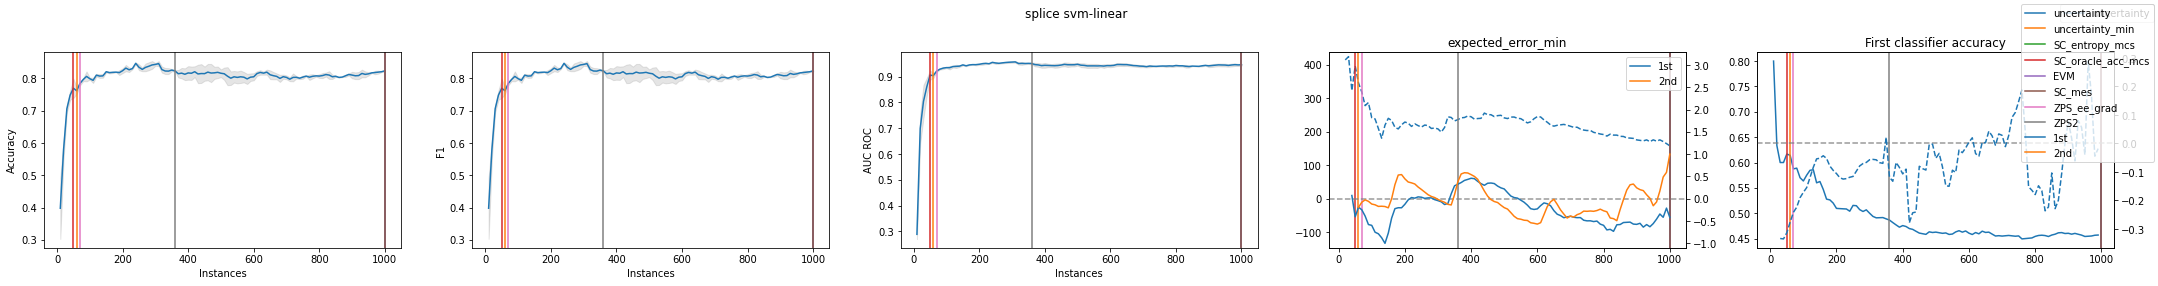

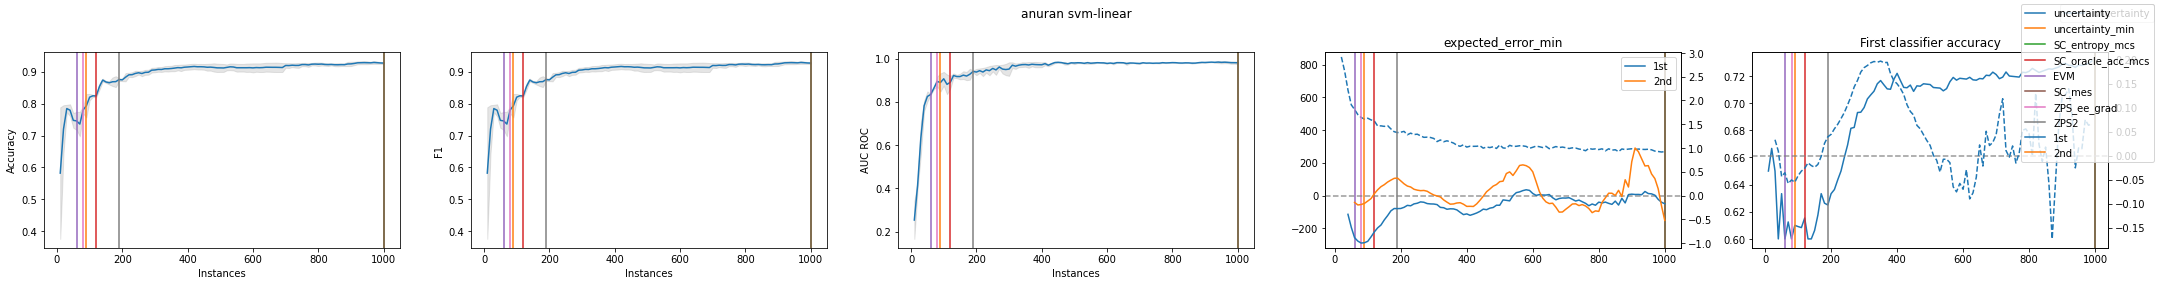

In [62]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Noise (30%)

In [59]:
def noise():
    pass
matrix = {
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        #("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "noise30": partial(noise, amount=3e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}


In [60]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

Experiment:   0%|          | 0/7 [00:00<?, ?it/s]

In [61]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

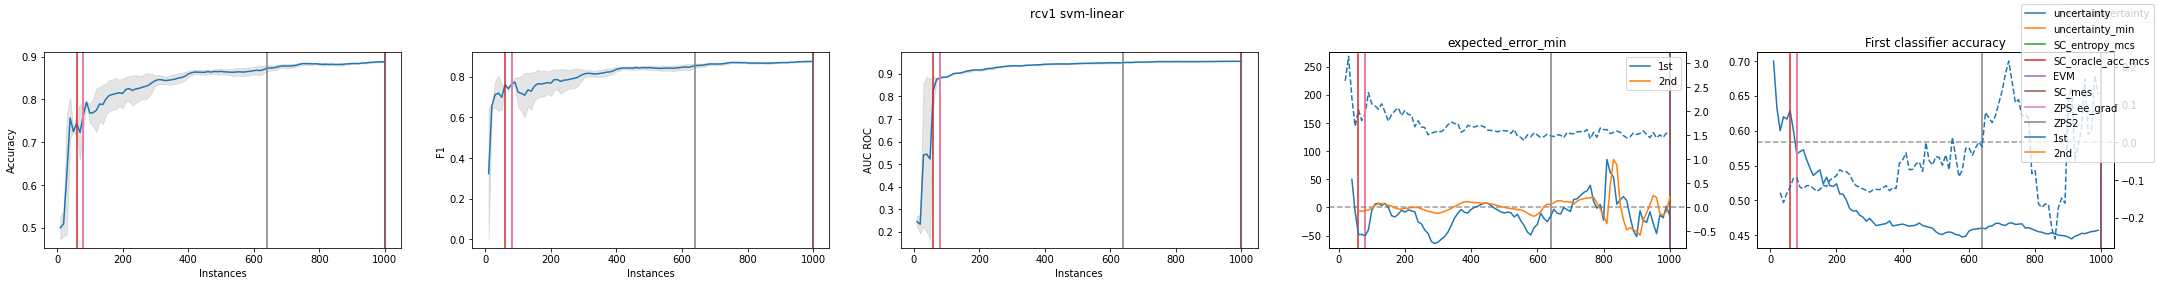

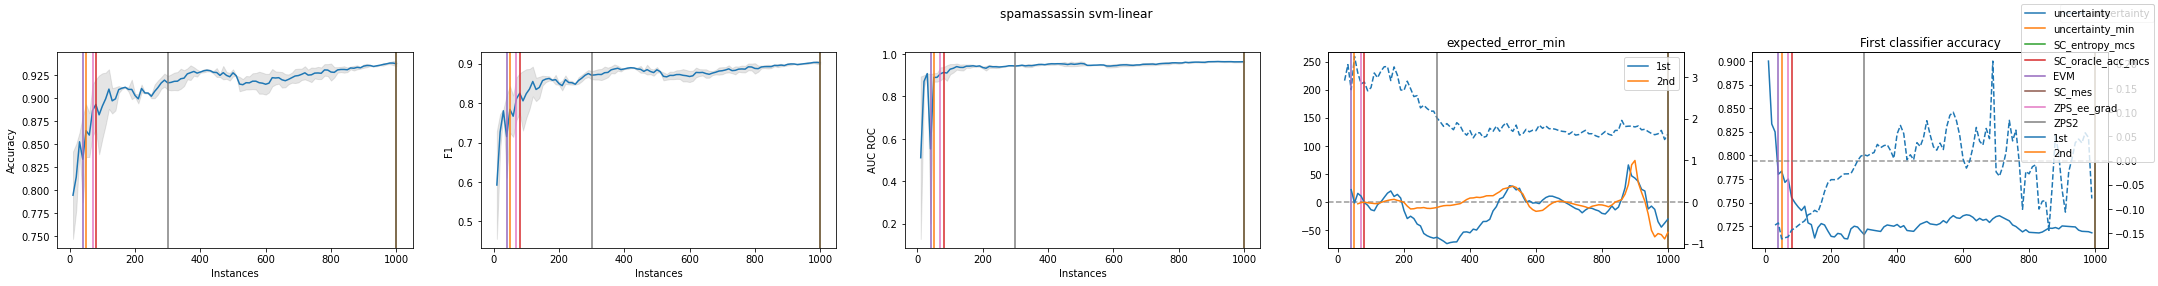

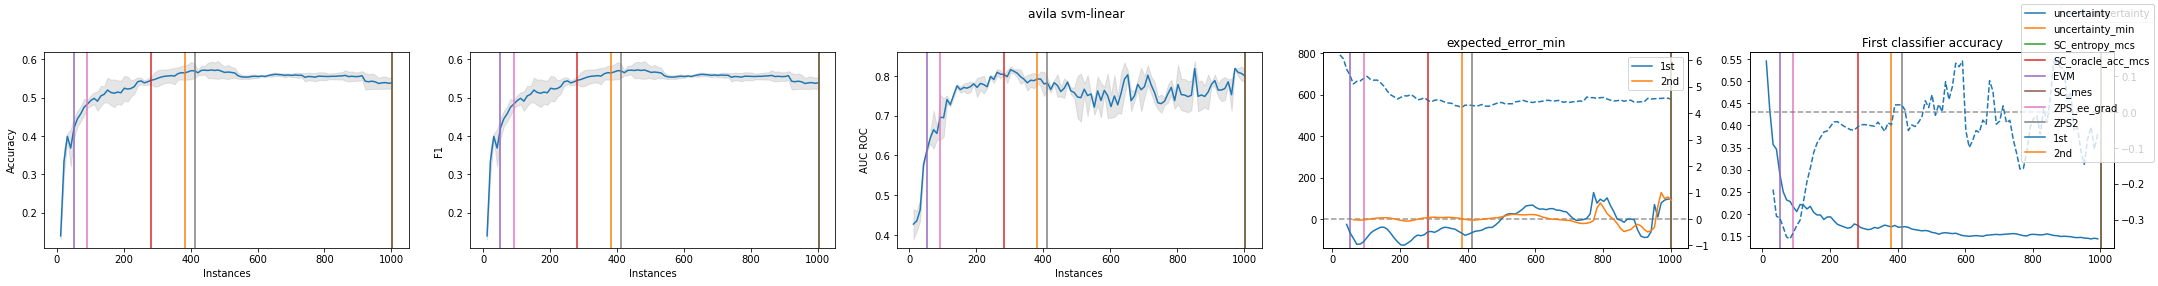

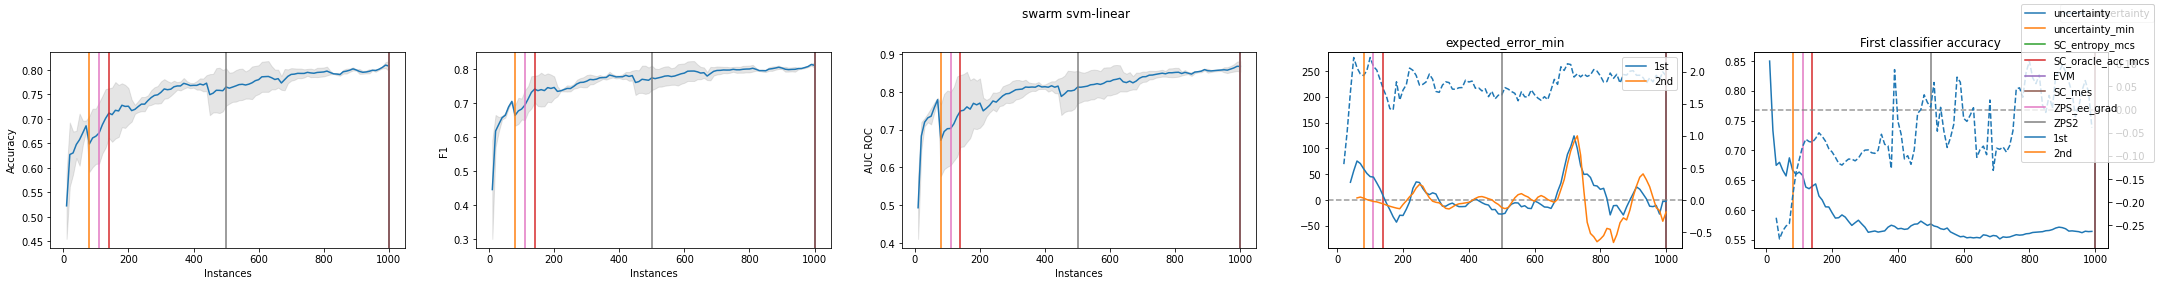

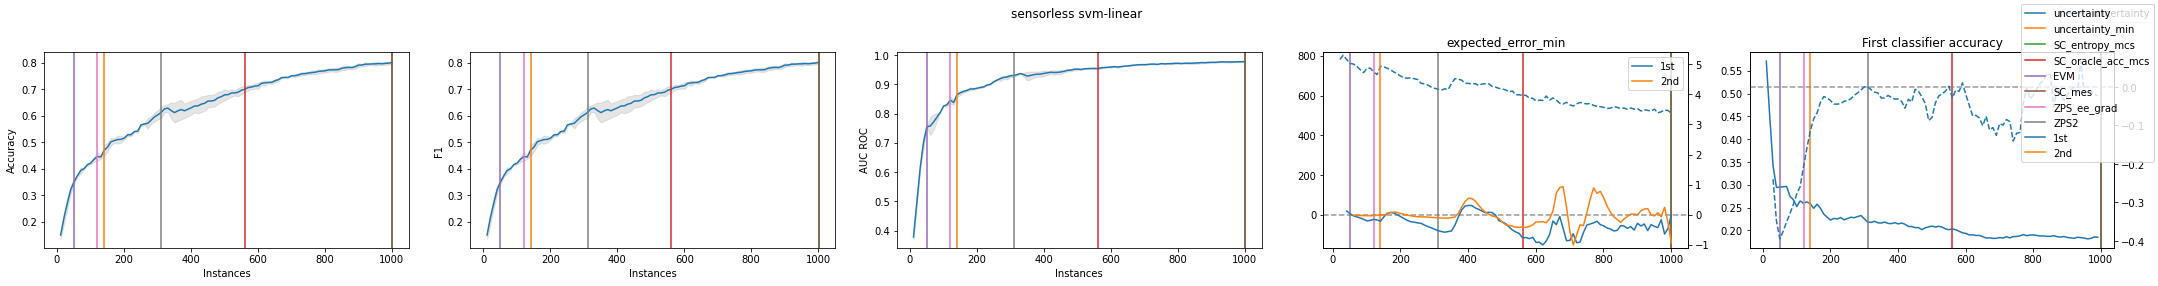

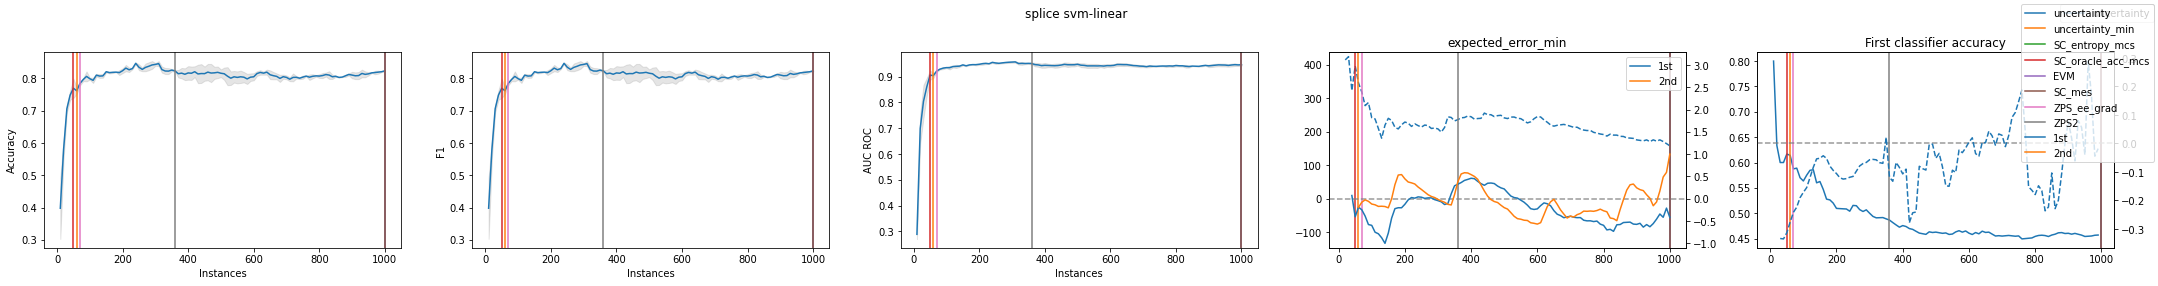

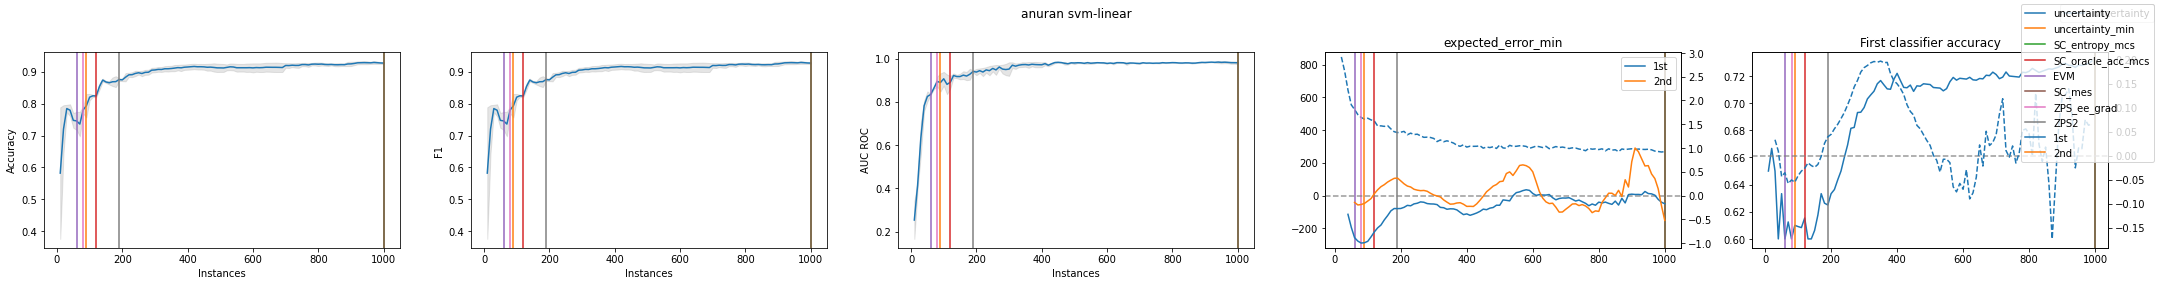

In [62]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Noise (40%)

In [5]:
def noise():
    pass
matrix = {
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        #("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "noise40": partial(noise, amount=4e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}


In [60]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

Experiment:   0%|          | 0/7 [00:00<?, ?it/s]

In [61]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

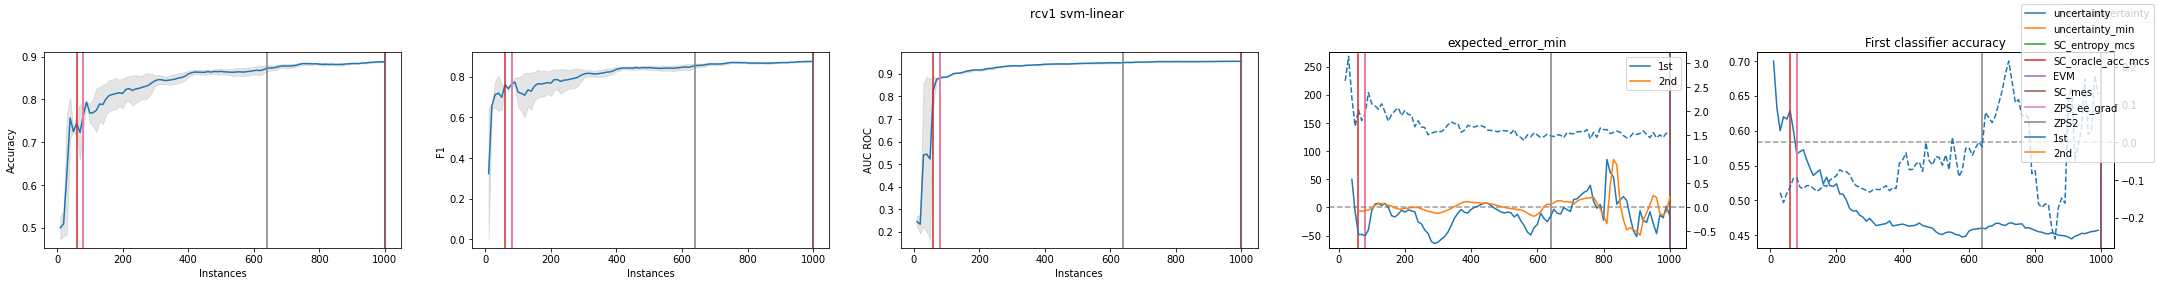

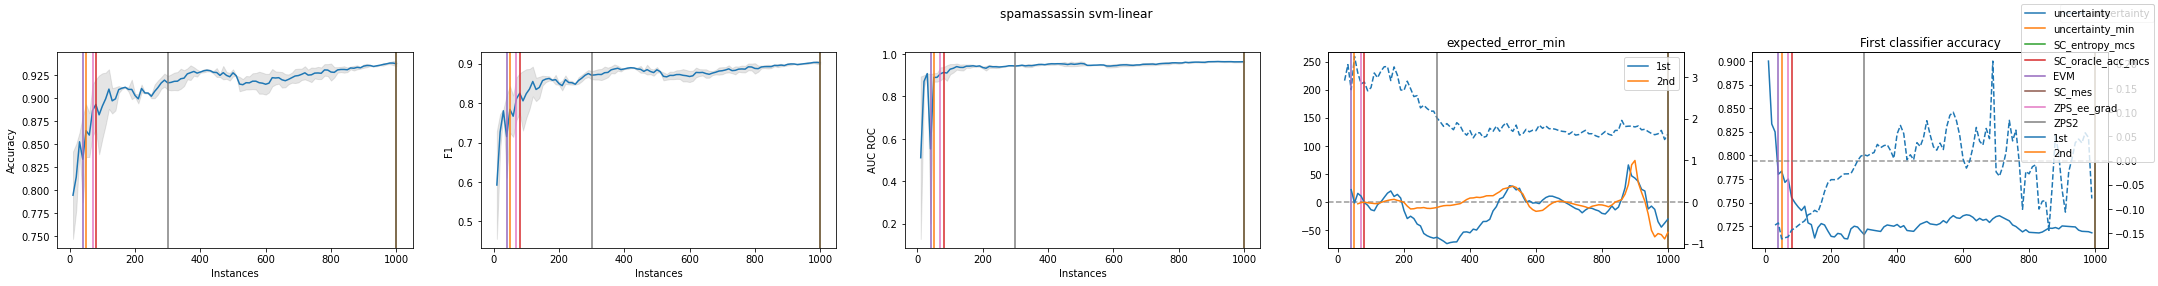

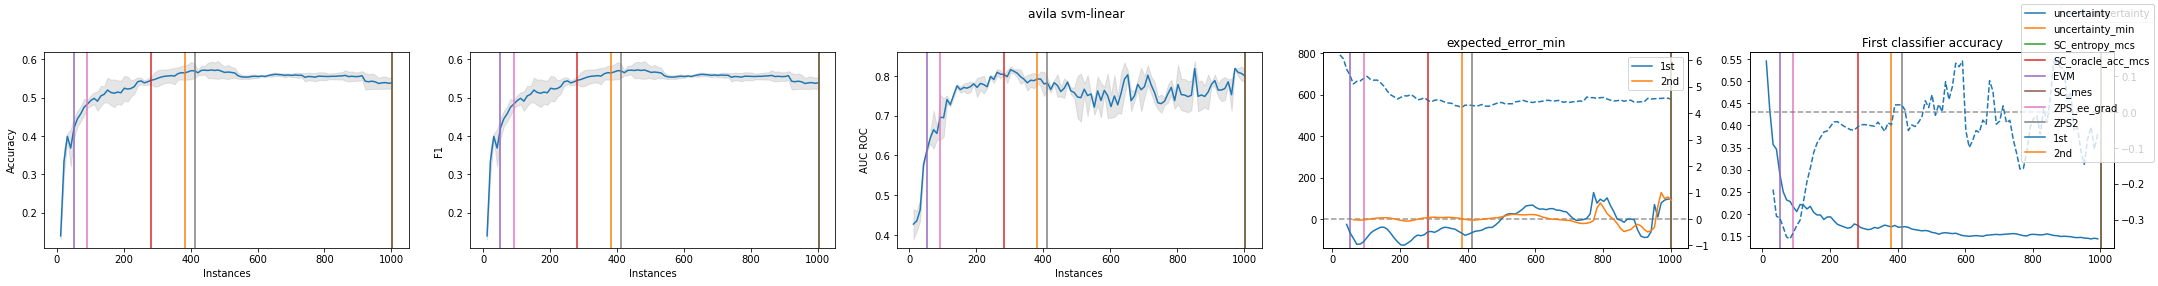

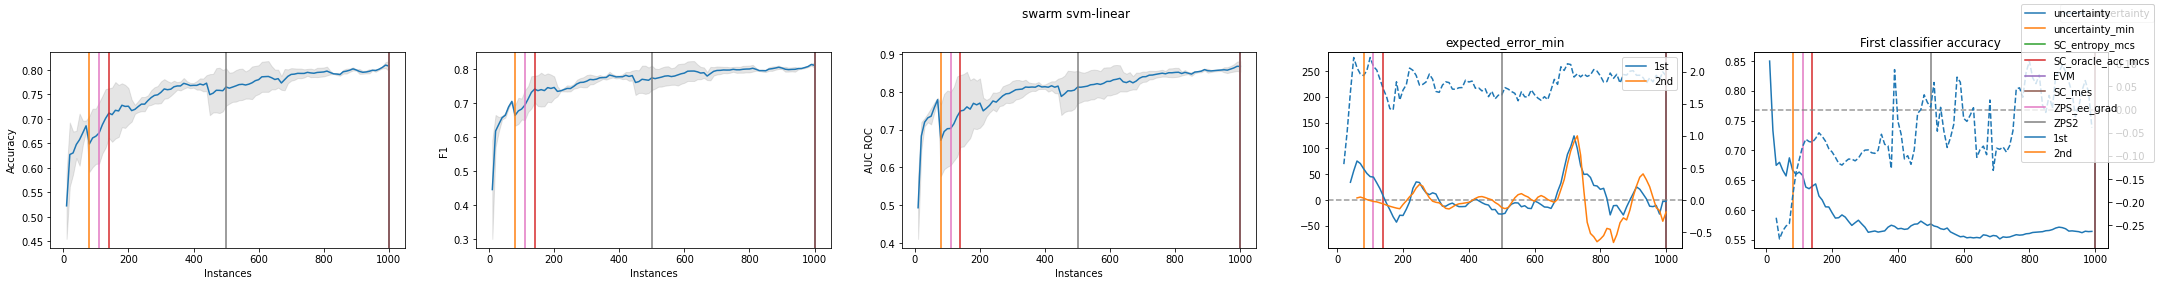

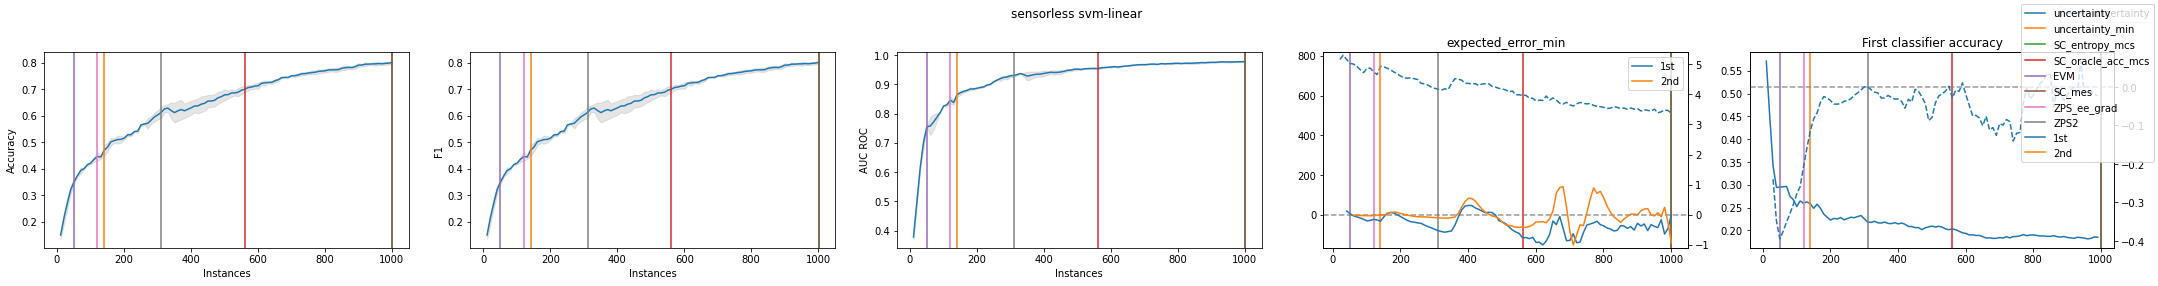

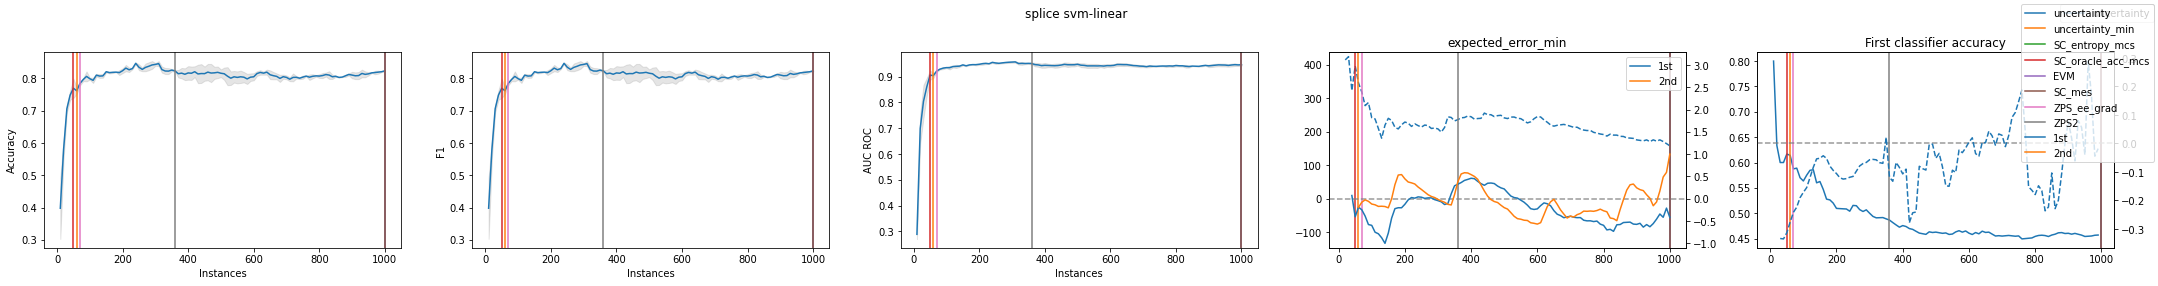

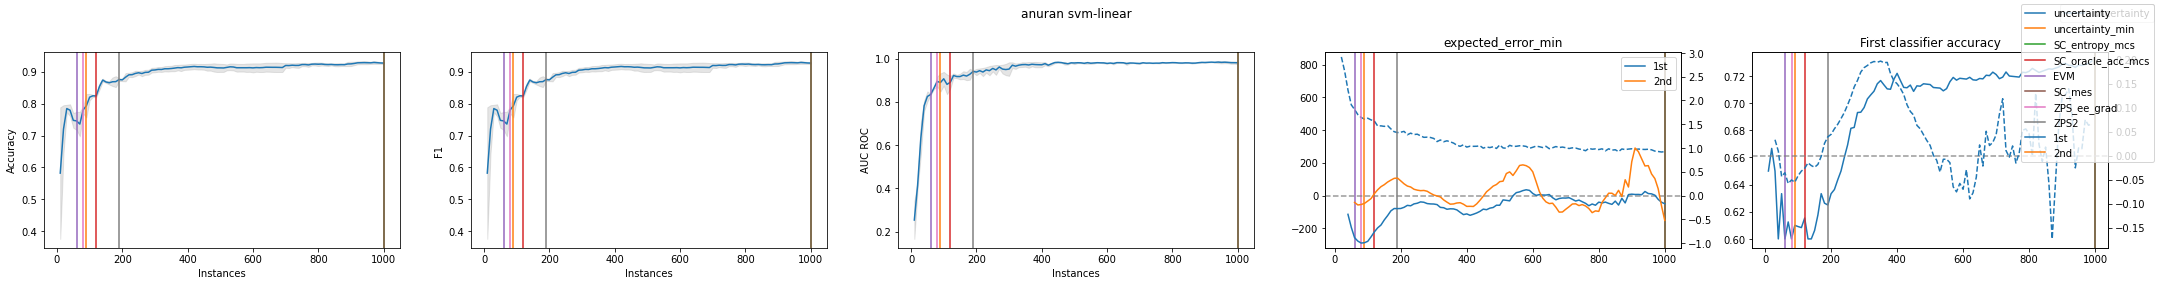

In [62]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Decision Tree

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [3]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-2762789c-36dc-4bca-bd11-44691263bc74.json']


Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

In [48]:
reload(libstop)
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8
results_plots 8
results (10, 8)
results[:,0] (10,)
conditions 8


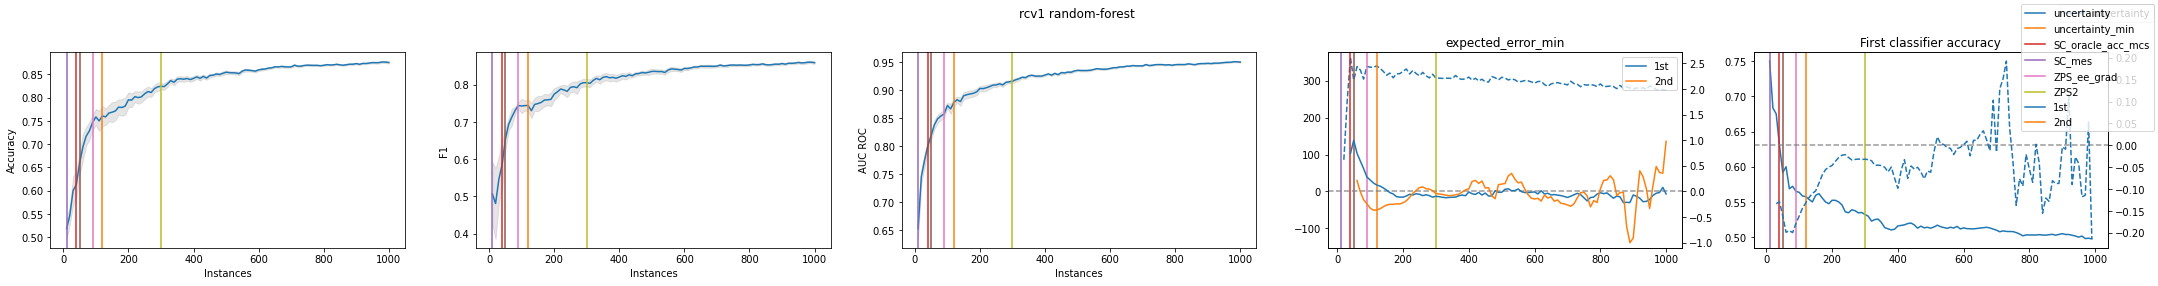

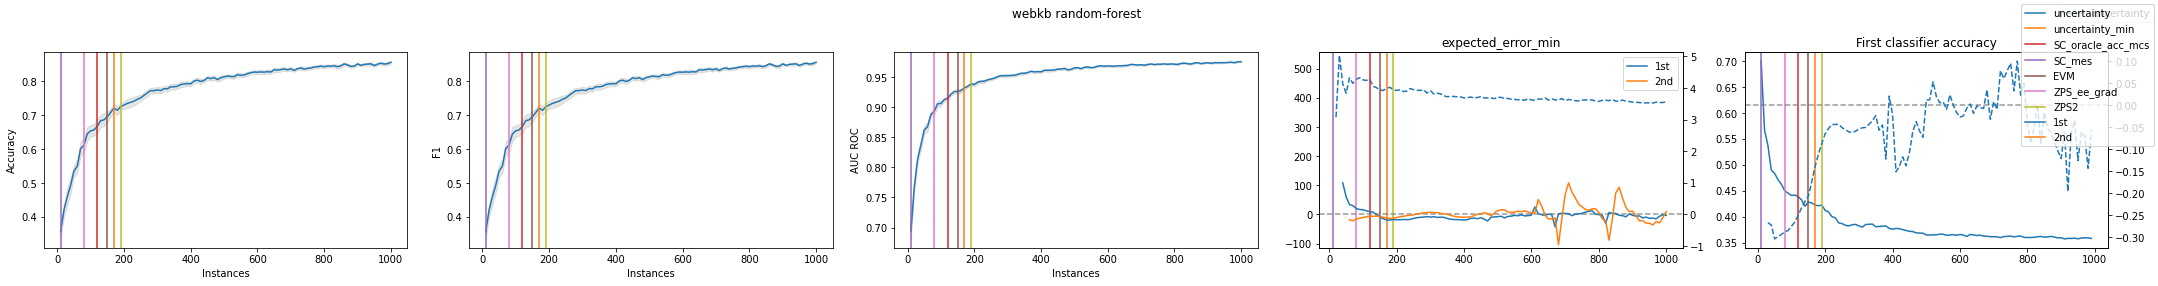

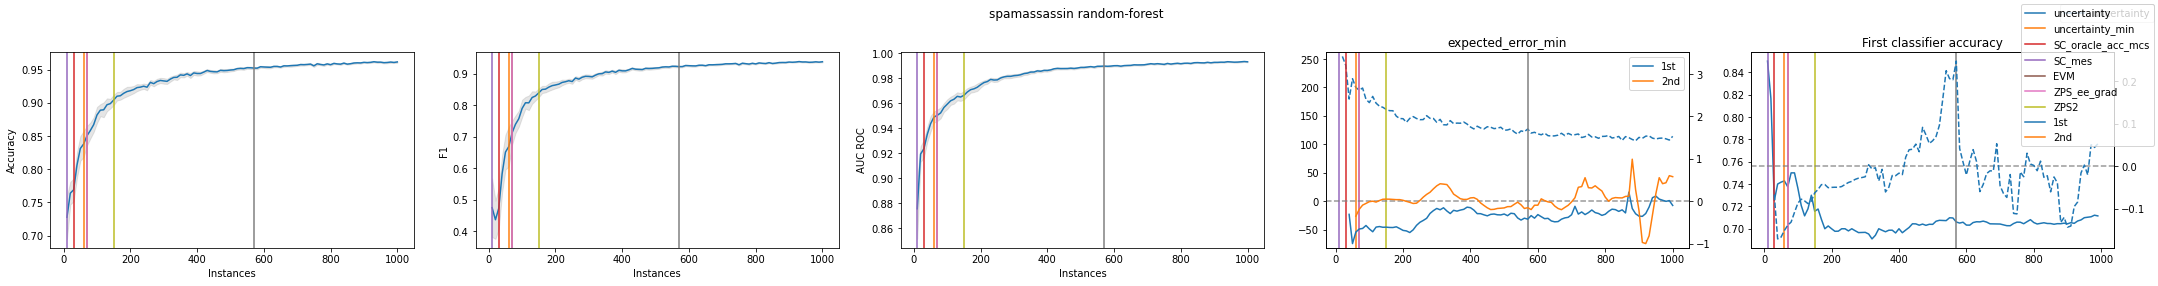

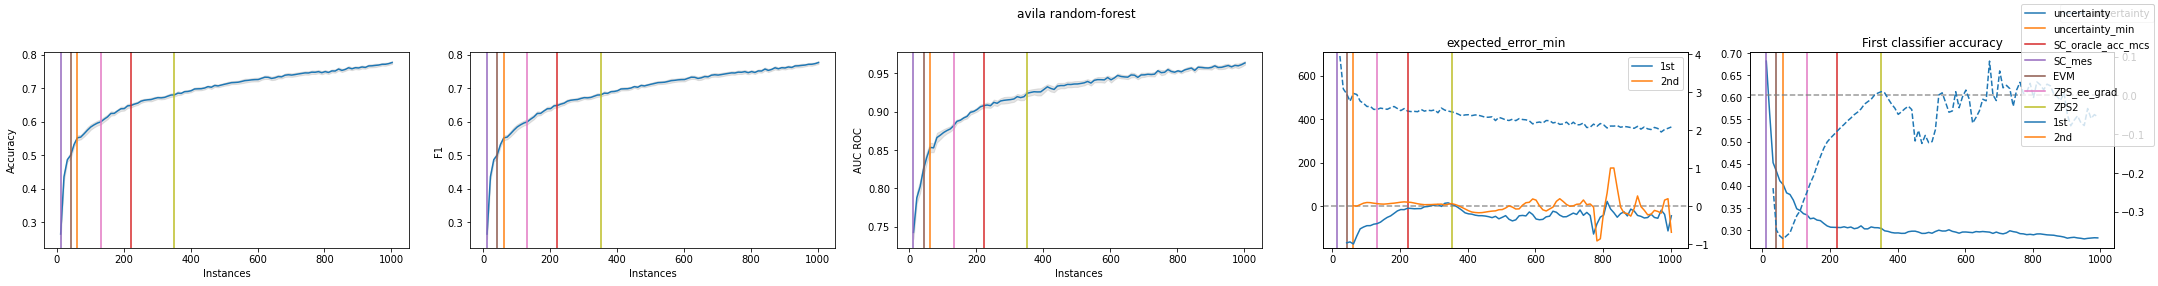

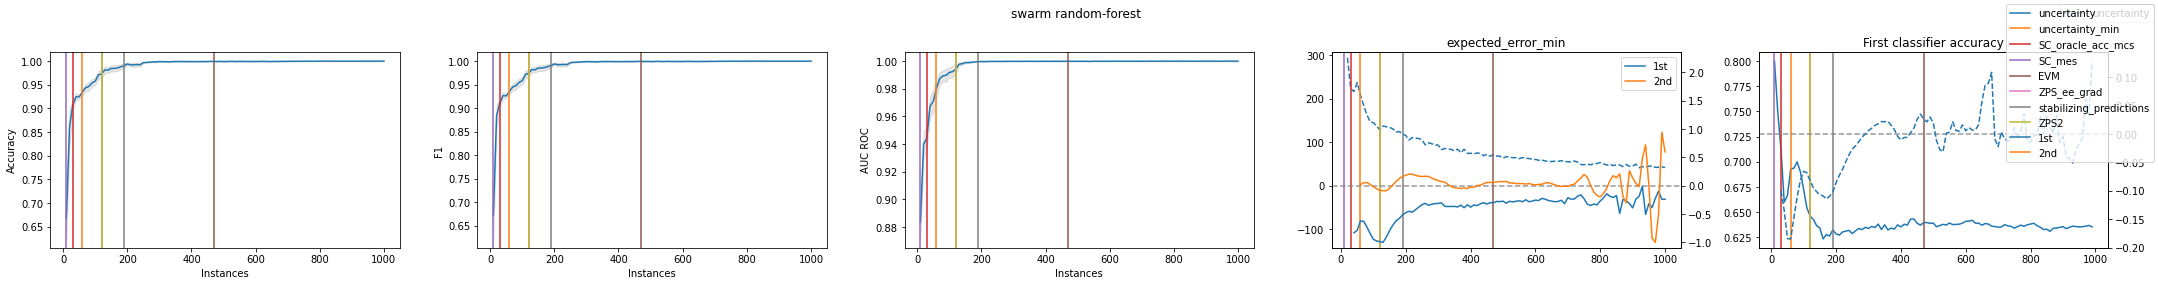

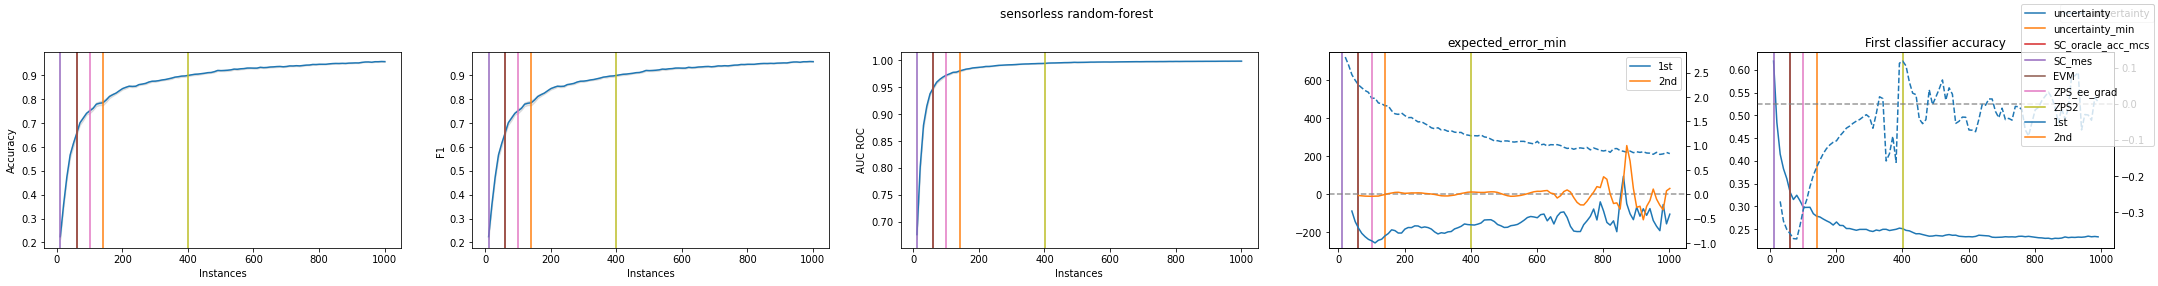

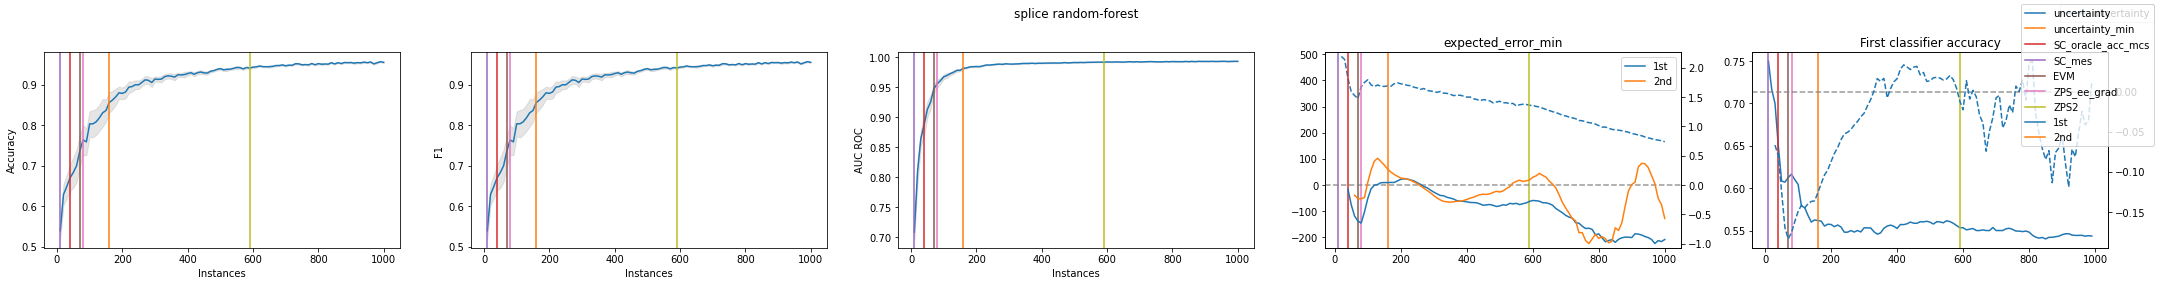

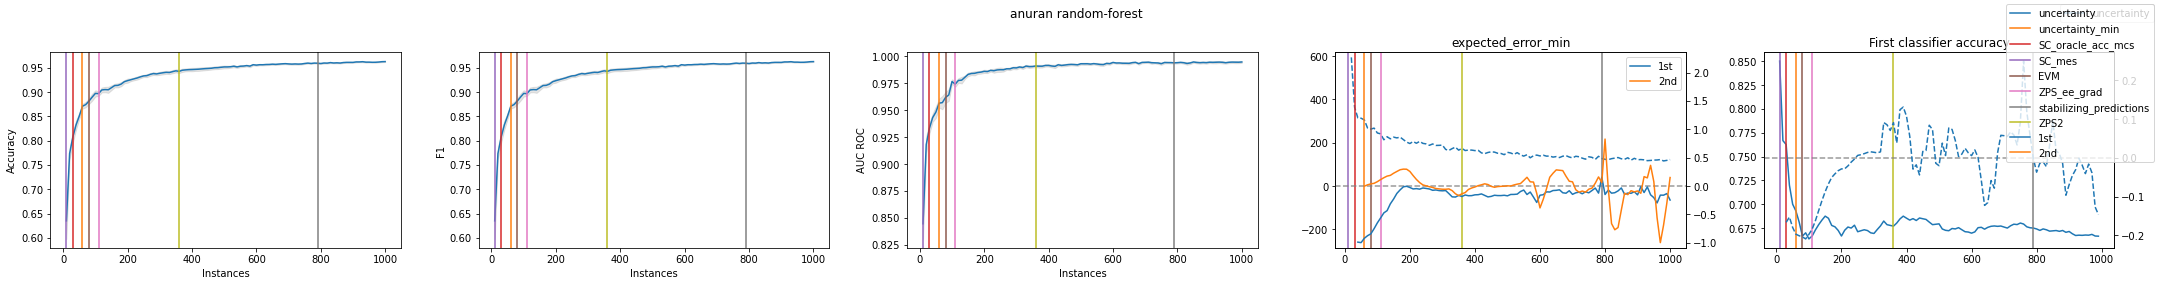

In [51]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

In [69]:
def f():
    for dataset, results in stop_results.items():
        for method, runs in results.items():
            percent = np.count_nonzero(runs)/len(runs)
            if percent != 1:
                yield (method, dataset, f"{percent:.0%}")
                
print(tabulate(sorted(list(f()), key=lambda x: (x[0], x[1])), headers=['Method', 'Dataset', 'Percent stopped']))

Method                   Dataset       Percent stopped
-----------------------  ------------  -----------------
EVM                      rcv1          20%
EVM                      spamassassin  20%
EVM                      splice        20%
EVM                      webkb         60%
SC_entropy_mcs           anuran        0%
SC_entropy_mcs           avila         0%
SC_entropy_mcs           rcv1          0%
SC_entropy_mcs           sensorless    0%
SC_entropy_mcs           spamassassin  0%
SC_entropy_mcs           splice        0%
SC_entropy_mcs           swarm         0%
SC_entropy_mcs           webkb         0%
stabilizing_predictions  anuran        50%
stabilizing_predictions  avila         0%
stabilizing_predictions  rcv1          0%
stabilizing_predictions  sensorless    0%
stabilizing_predictions  spamassassin  60%
stabilizing_predictions  splice        0%
stabilizing_predictions  webkb         0%


In [57]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'instances');

[[120.0, 120.0, 190.0, 110.0, 120.0, 170.0, 50.0, 160.0, 60.0, 70.0, 170.0, 210.0, 380.0, 100.0, 170.0, 190.0, 320.0, 420.0, 130.0, 180.0, 60.0, 60.0, 60.0, 60.0, 50.0, 60.0, 70.0, 70.0, 60.0, 60.0, 62.0, 112.0, 102.0, 82.0, 62.0, 72.0, 92.0, 92.0, 92.0, 82.0, 60.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 60.0, 50.0, 60.0, 141.0, 101.0, 131.0, 121.0, 161.0, 111.0, 101.0, 161.0, 131.0, 111.0, 160.0, 160.0, 120.0, 180.0, 80.0, 140.0, 140.0, 250.0, 100.0, 70.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 70.0, 60.0, 60.0], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,

C:\Users\Zac\Programming\python\research\libstop.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


ValueError: Shape of passed values is (8, 1), indices imply (8, 8)

In [53]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'roc_auc_score');

C:\Users\Zac\Programming\python\research\libstop.py:848: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = pd.DataFrame(np.array(data).T, columns=list(stop_results[list(stop_results.keys())[0]].keys()))


ValueError: Shape of passed values is (8, 1), indices imply (8, 8)

# Random Forest

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [11]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-2762789c-36dc-4bca-bd11-44691263bc74.json']


Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
reload(libstop)
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

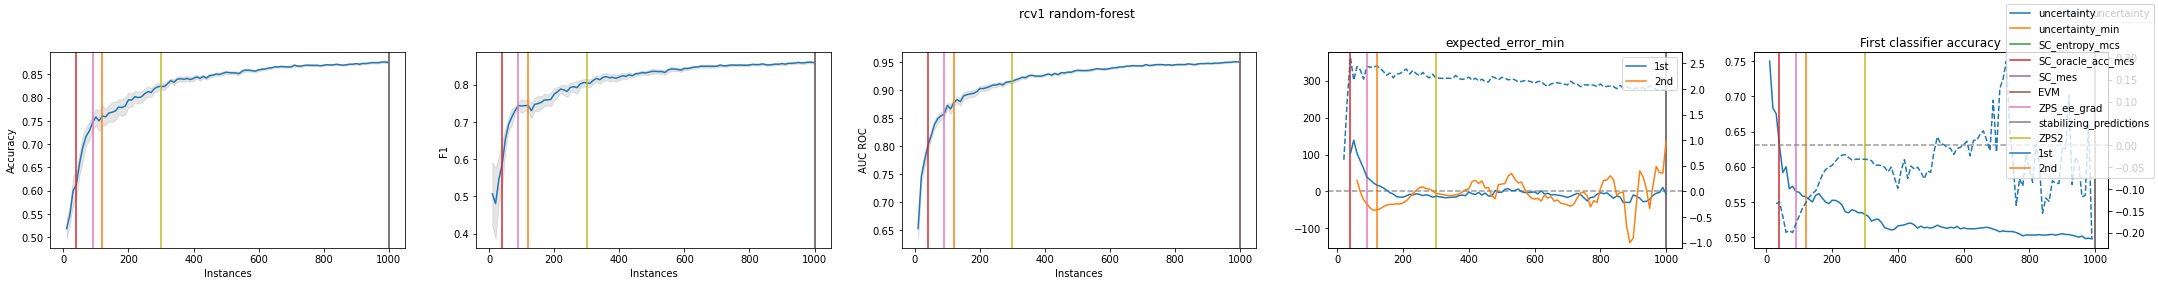

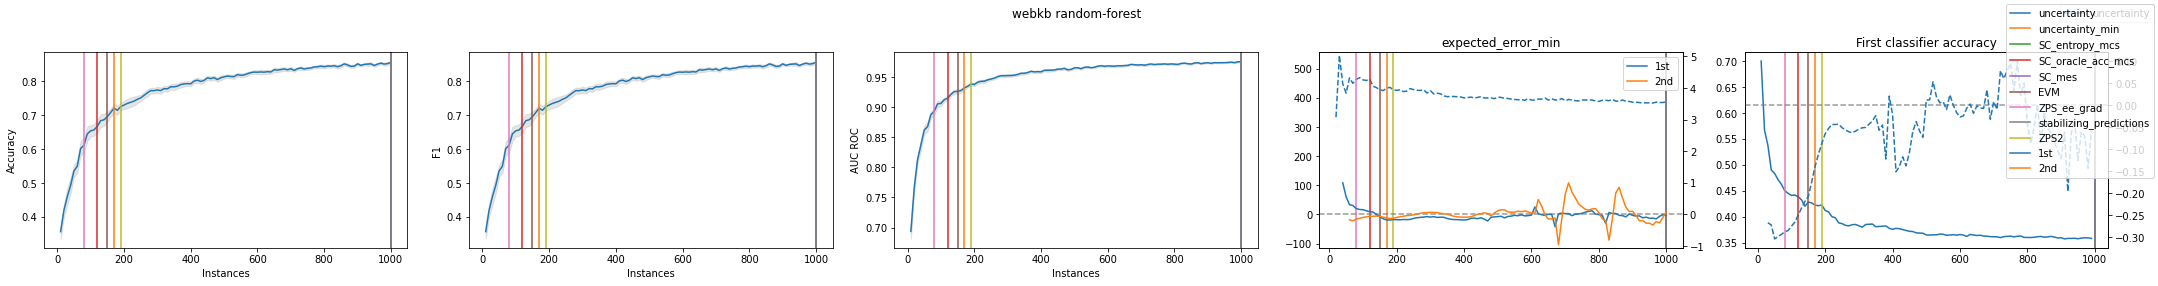

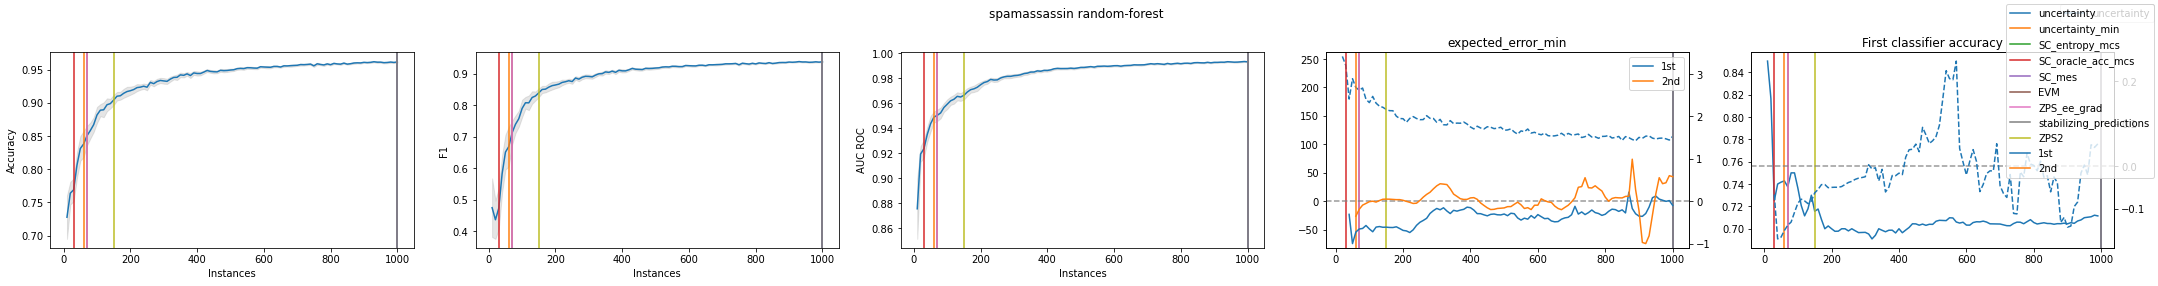

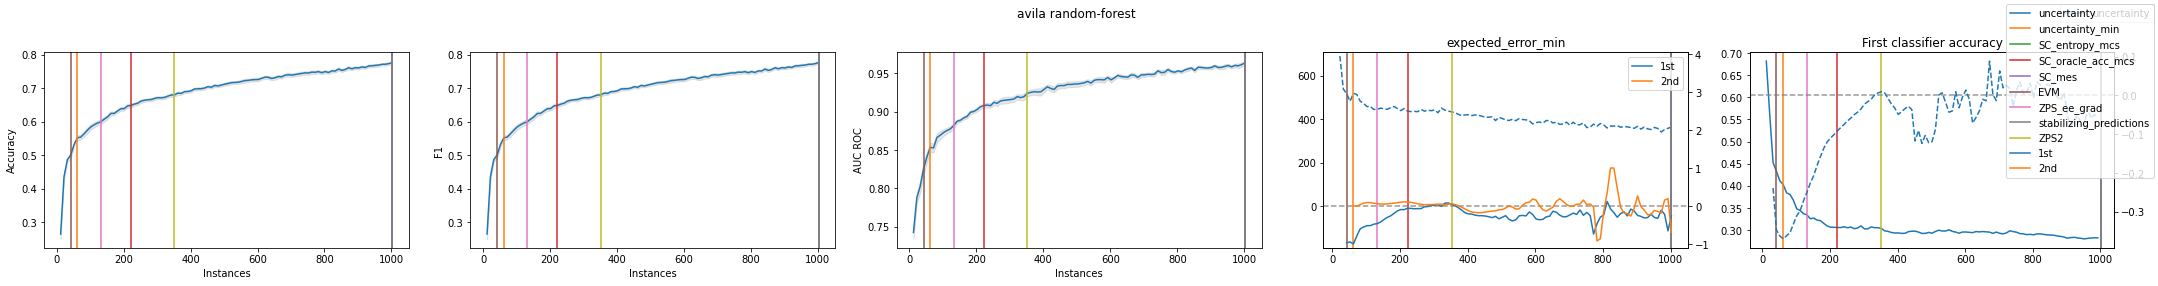

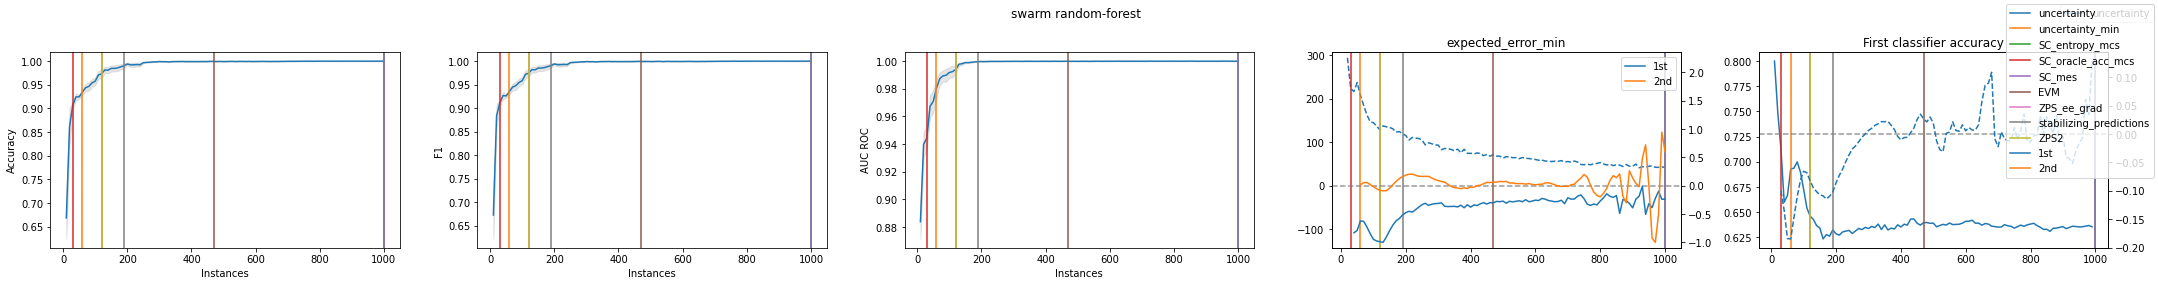

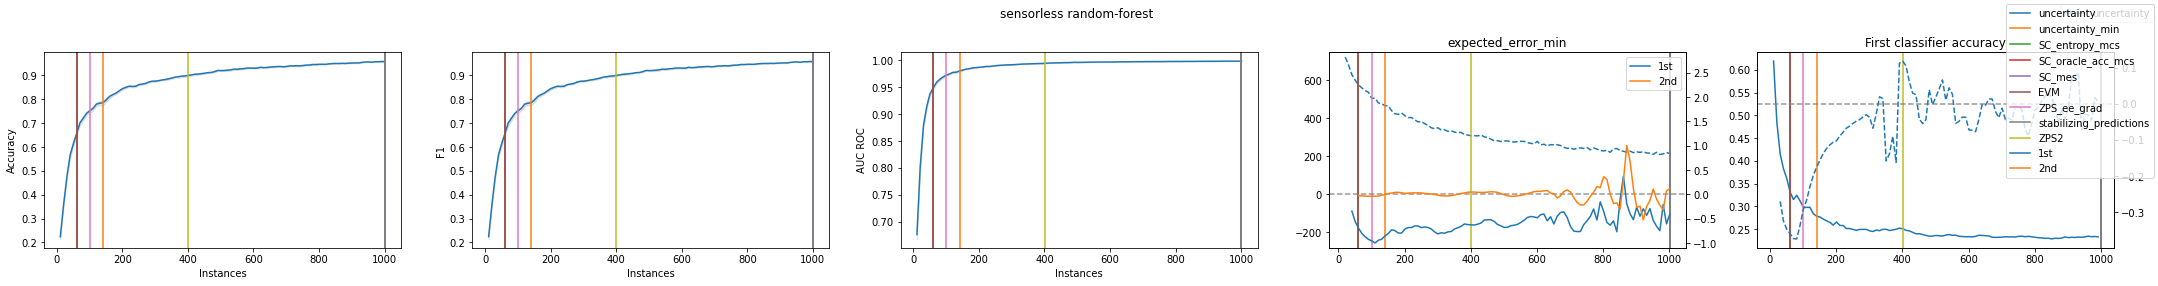

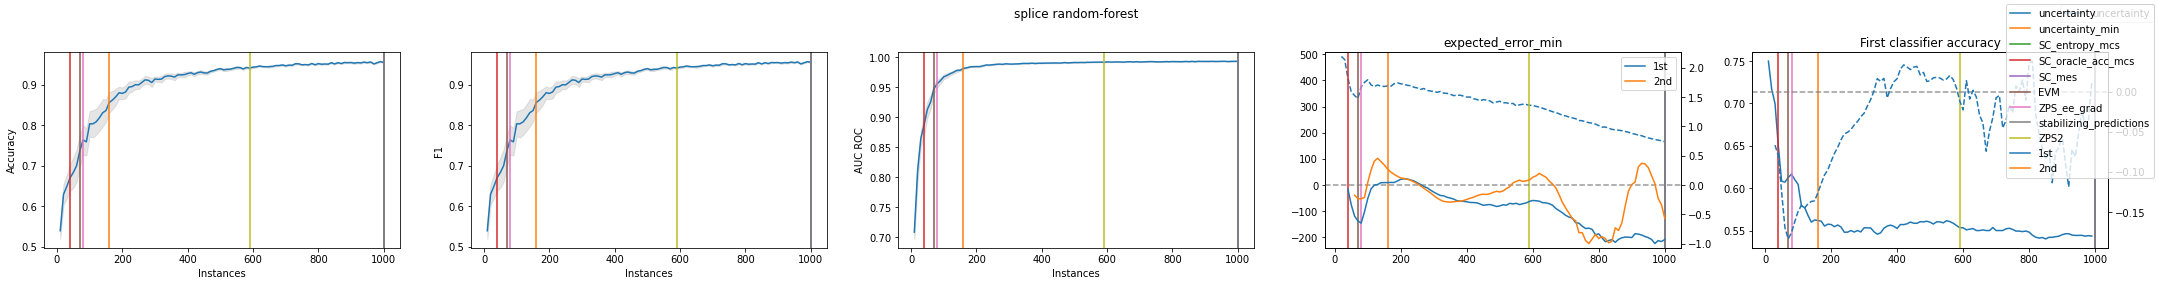

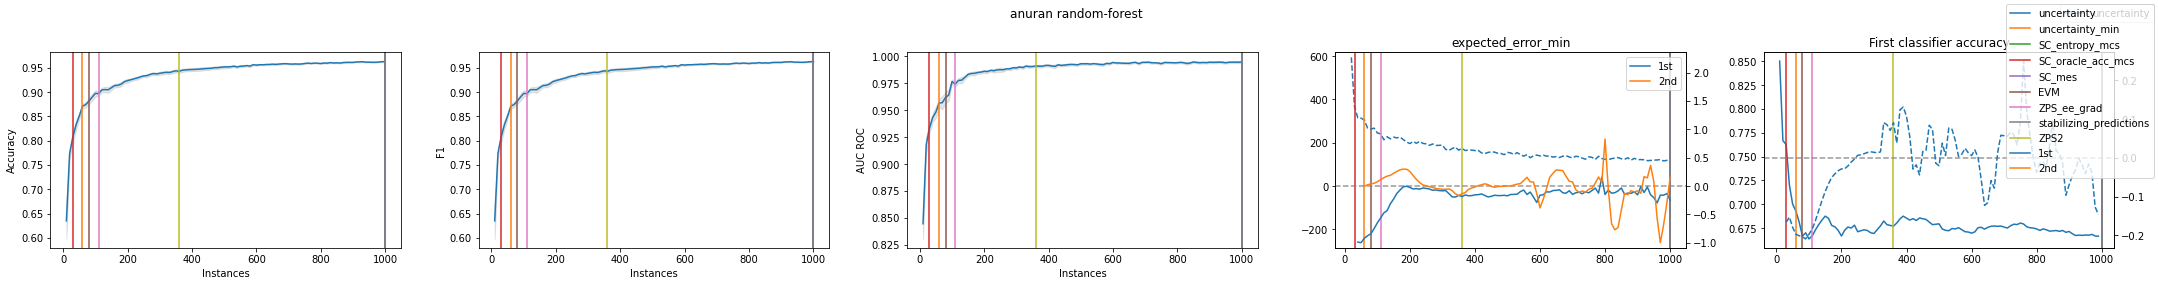

In [13]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

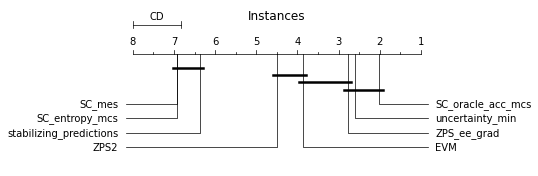

In [14]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'instances');

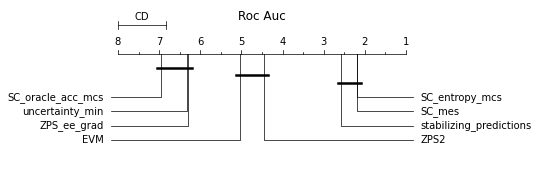

In [15]:
reload(libstop); from libstop import rank_stop_conds
rank_stop_conds(stop_results, results_plots, 'roc_auc_score');

# Neural Network

In [42]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        #("rcv1", wrap(rcv1, None)),
        #("webkb", wrap(webkb, None)),
        #("spamassassin", wrap(spamassassin, None)),
        #("avila", wrap(avila, None)),
        #("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        #("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "neural-network"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [43]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-7f0993fa-2d6f-45f3-9599-1a75289cf4a8.json']


Experiment:   0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

C:\Users\Zac\Programming\python\research\libactive.py:71: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if klass not in Y_labelled:
C:\Users\Zac\Programming\python\research\libactive.py:734: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[rows] = False
C:\Users\Zac\Programming\python\research\libactive.py:71: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if klass not in Y_labelled:


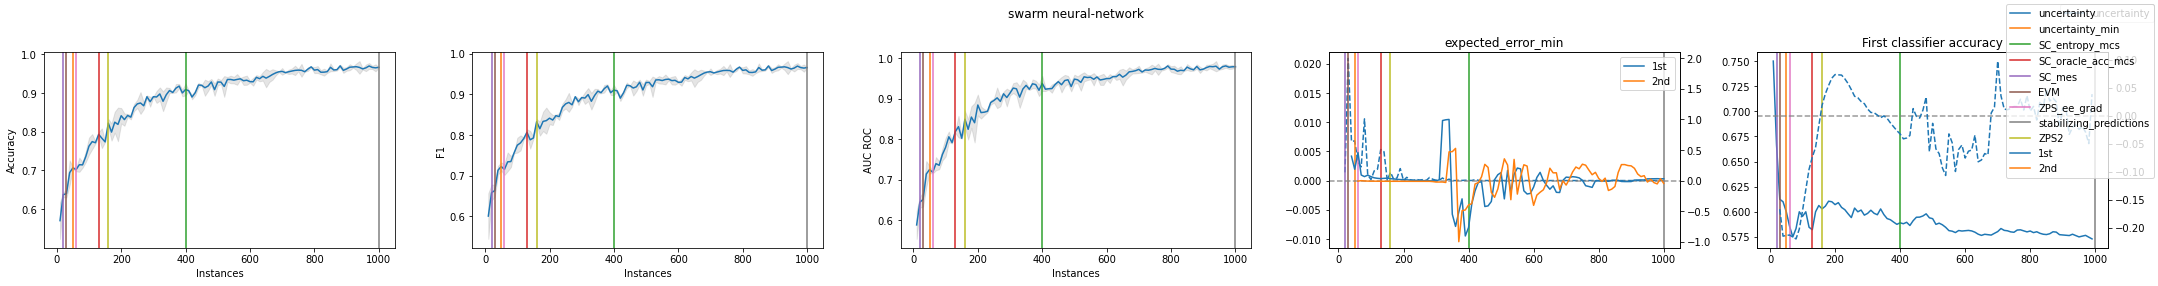

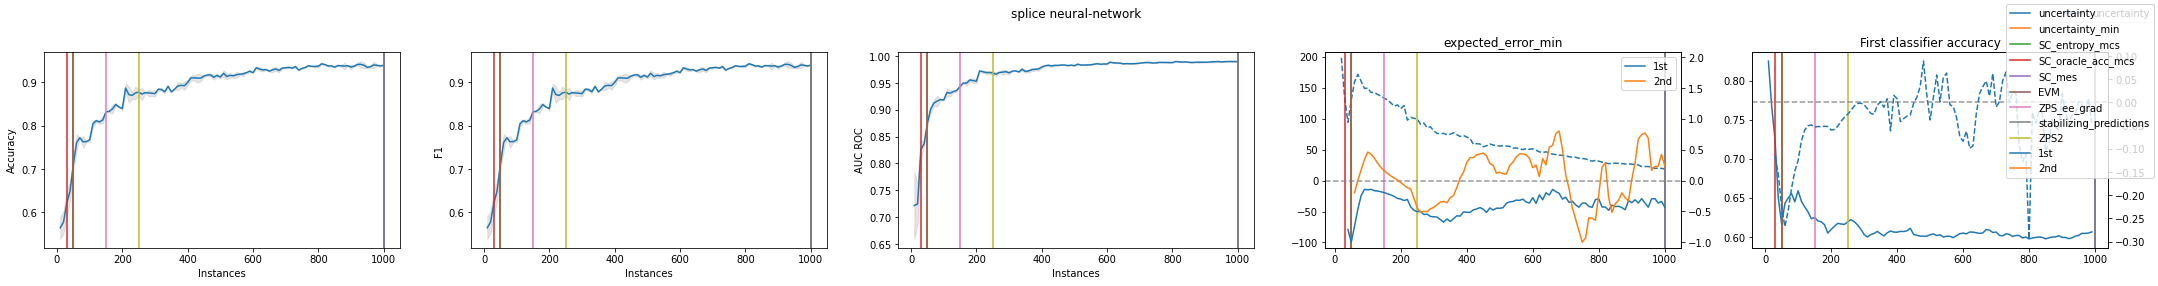

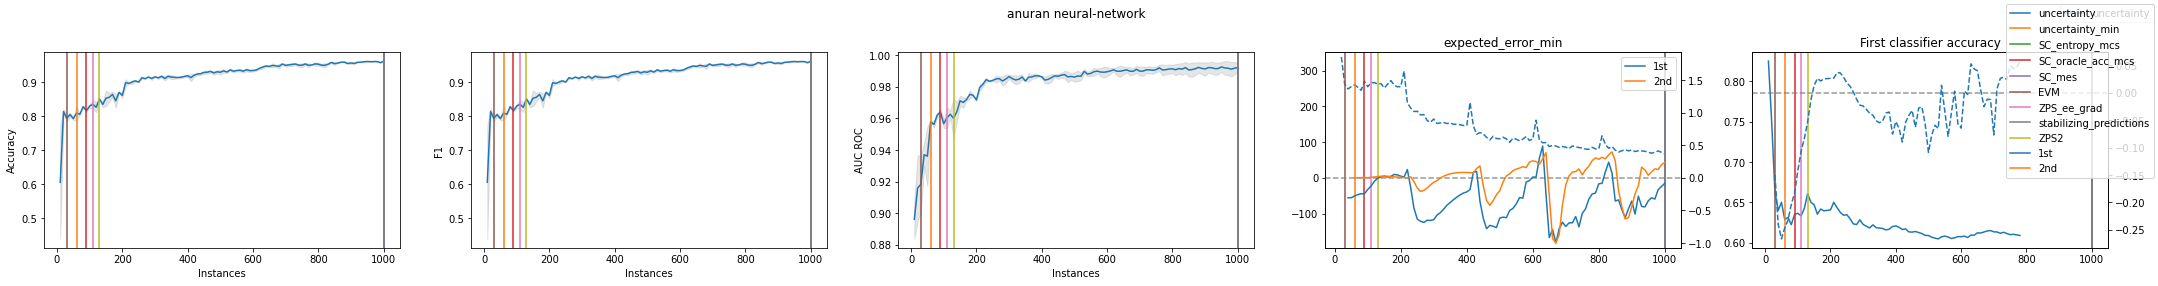

In [45]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Unbalanced

In [2]:
def unbalanced(X_train, X_test, y_train, y_test, amount=1e-1, rand=None, config_str=None, i=None, test_size=None, shuffle=None, **kwargs):
    pass

matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)

    # rcv1, sensorless, anuran are the only datasets to have >3000 instances after being unbalanced
    # maybe a different approach is better? Something non-binary?
    "datasets": [
        ("rcv1", wrap(rcv1, None)),
        ("sensorless", wrap(sensorless, None)),
        ("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "unbalanced10": partial(unbalanced, amount=1e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [4]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

Experiment:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

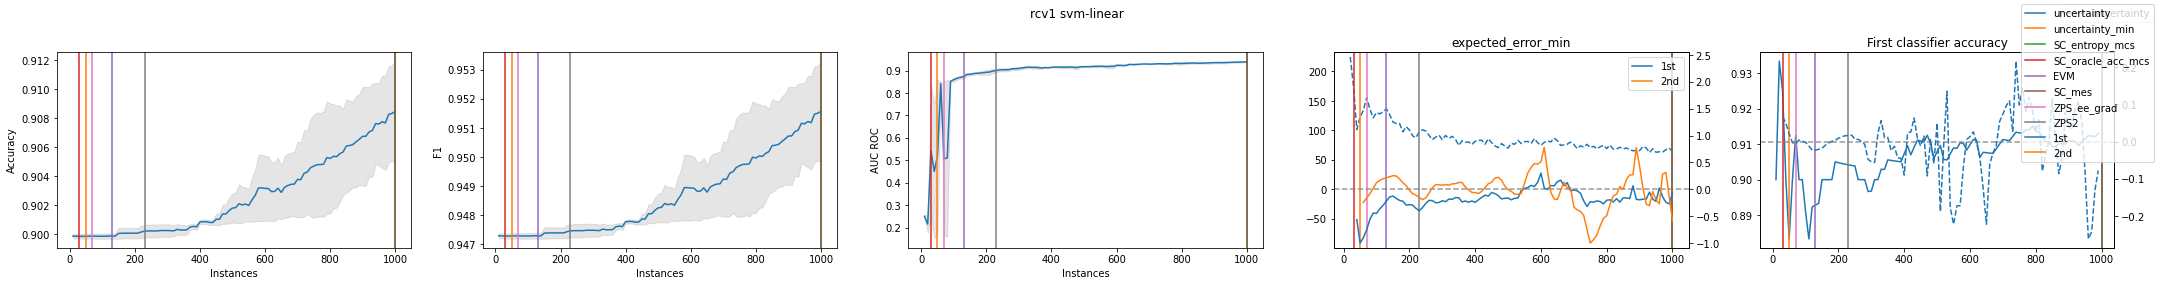

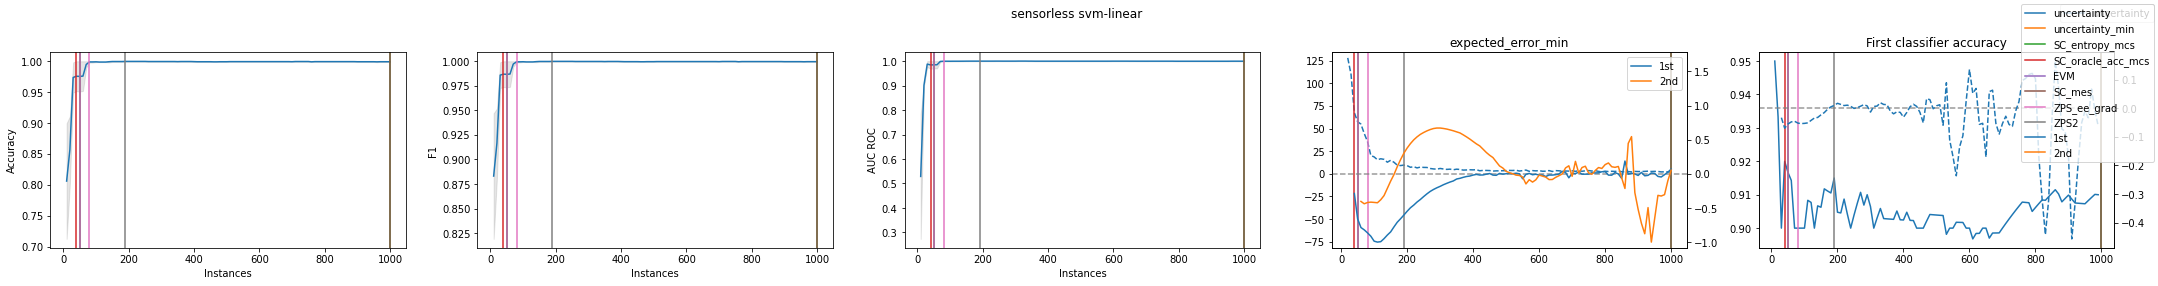

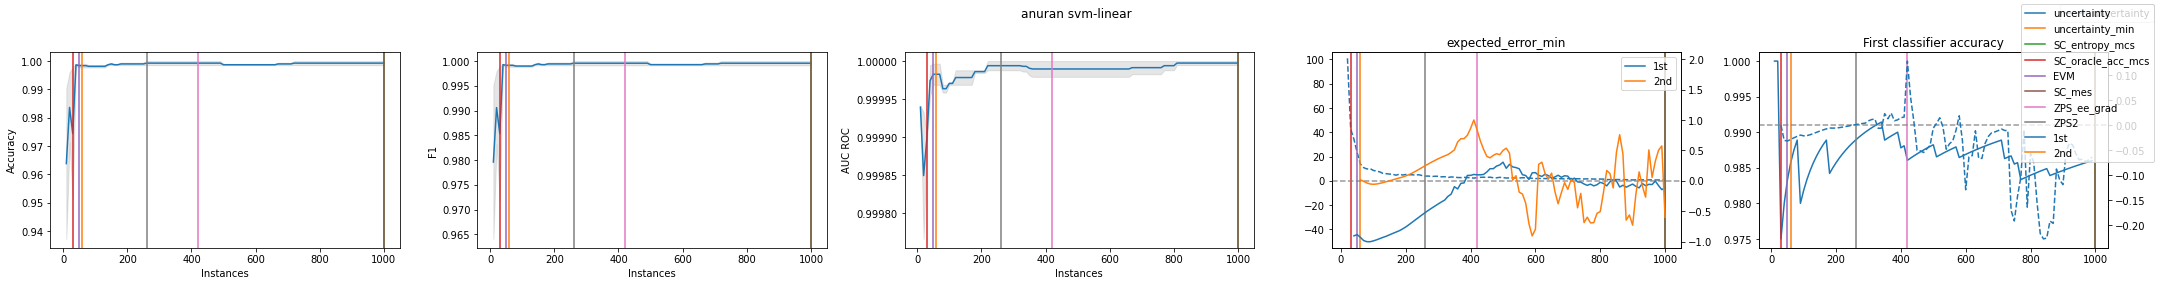

In [6]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

It seems like making the datasets binary made it too easy to create perfectly accurate classifiers. I don't know if reducing the balance further will really help.

# Unbalanced 2

In [46]:
def unbalanced(X_train, X_test, y_train, y_test, amount=1e-1, rand=None, config_str=None, i=None, test_size=None, shuffle=None, **kwargs):
    pass

matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)

    # rcv1, sensorless, anuran are the only datasets to have >3000 instances after being unbalanced
    # maybe a different approach is better? Something non-binary?
    "datasets": [
        #("rcv1", wrap(rcv1, None)),
        ("sensorless", wrap(sensorless, None)),
        #("anuran", wrap(anuran, None)),
    ],
    "dataset_mutators": {
        "unbalanced2-50": partial(unbalanced, amount=1e-1)
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [47]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-7f0993fa-2d6f-45f3-9599-1a75289cf4a8.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

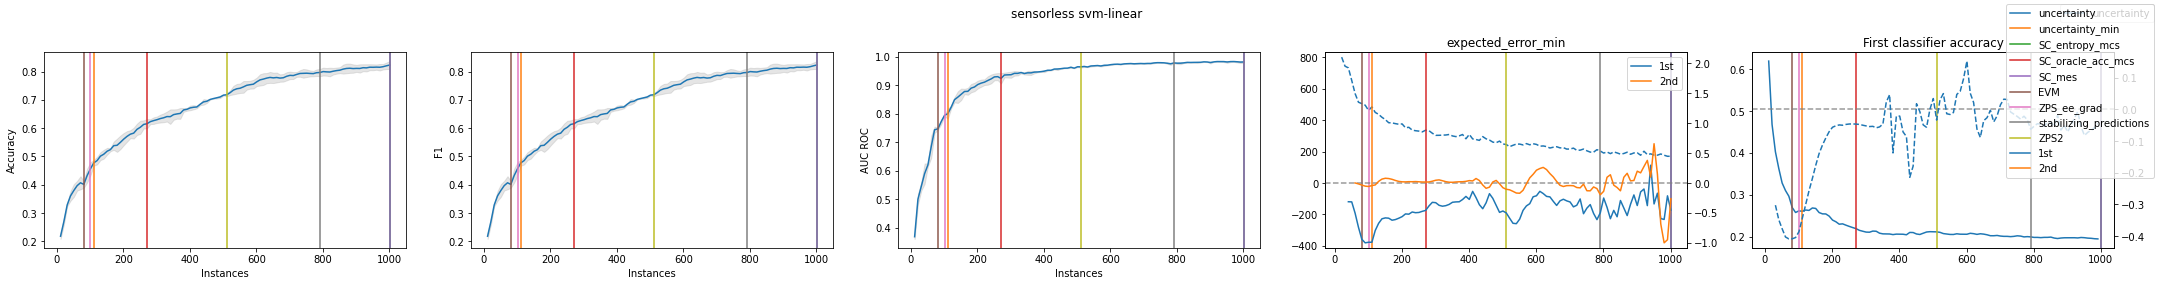

In [49]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))

# Labelled size (100)

In [21]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("newsgroups", wrap(newsgroups, None)),
        ("rcv1", wrap(rcv1, None)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 100,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [22]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=5)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-2762789c-36dc-4bca-bd11-44691263bc74.json']


Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
for plots, clfs in zip(results_plots, classifiers):
    for i, clfs_ in enumerate(clfs):
        if len(clfs_) != 100:
            print(f"{plots[0].dataset_name}_{i}.zip")

rcv1_0.zip
rcv1_1.zip
rcv1_2.zip
rcv1_3.zip
rcv1_4.zip
rcv1_5.zip
webkb_0.zip
webkb_1.zip
webkb_2.zip
webkb_3.zip
webkb_4.zip
webkb_5.zip
spamassassin_0.zip
spamassassin_1.zip
spamassassin_2.zip
spamassassin_3.zip
spamassassin_4.zip
spamassassin_5.zip
avila_0.zip
avila_1.zip
avila_2.zip
avila_3.zip
avila_4.zip
avila_5.zip
smartphone_0.zip
smartphone_1.zip
smartphone_2.zip
smartphone_3.zip
smartphone_4.zip
smartphone_5.zip
swarm_0.zip
swarm_1.zip
swarm_2.zip
swarm_3.zip
swarm_4.zip
swarm_5.zip
sensorless_0.zip
sensorless_1.zip
sensorless_2.zip
sensorless_3.zip
sensorless_4.zip
sensorless_5.zip
splice_0.zip
splice_1.zip
splice_2.zip
splice_3.zip
splice_4.zip
splice_5.zip
anuran_0.zip
anuran_1.zip
anuran_2.zip
anuran_3.zip
anuran_4.zip
anuran_5.zip


In [15]:
reload(libstop)
stop_conditions, stop_results = libstop.eval_stopping_conditions(results_plots, classifiers)

Exception: short classifier file: rcv1__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=100__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=l__pool_subsample=1000_0.zip
It has length 91 when it should have length 100

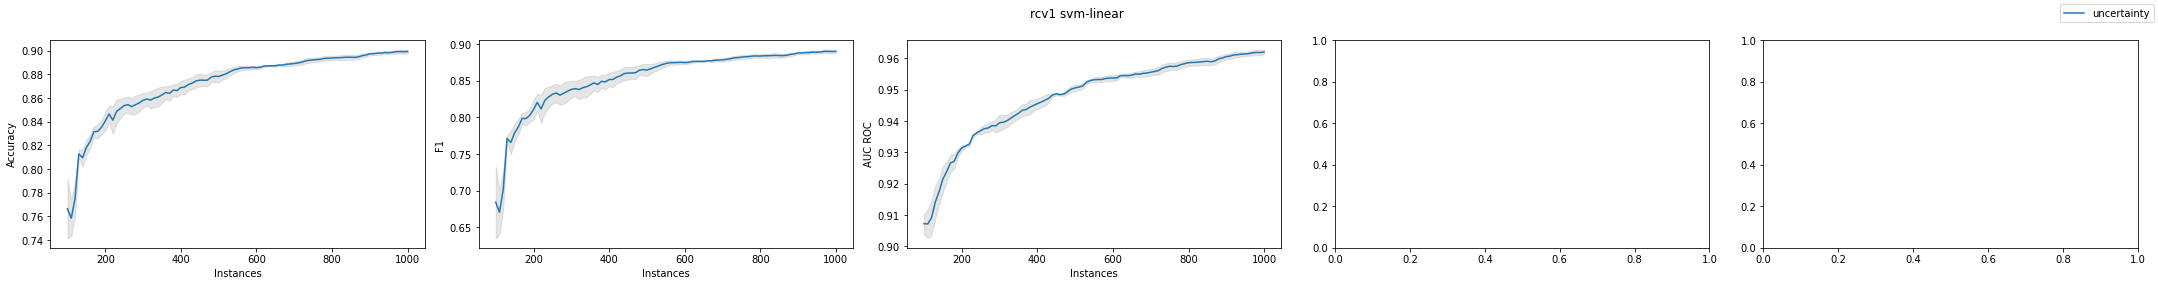

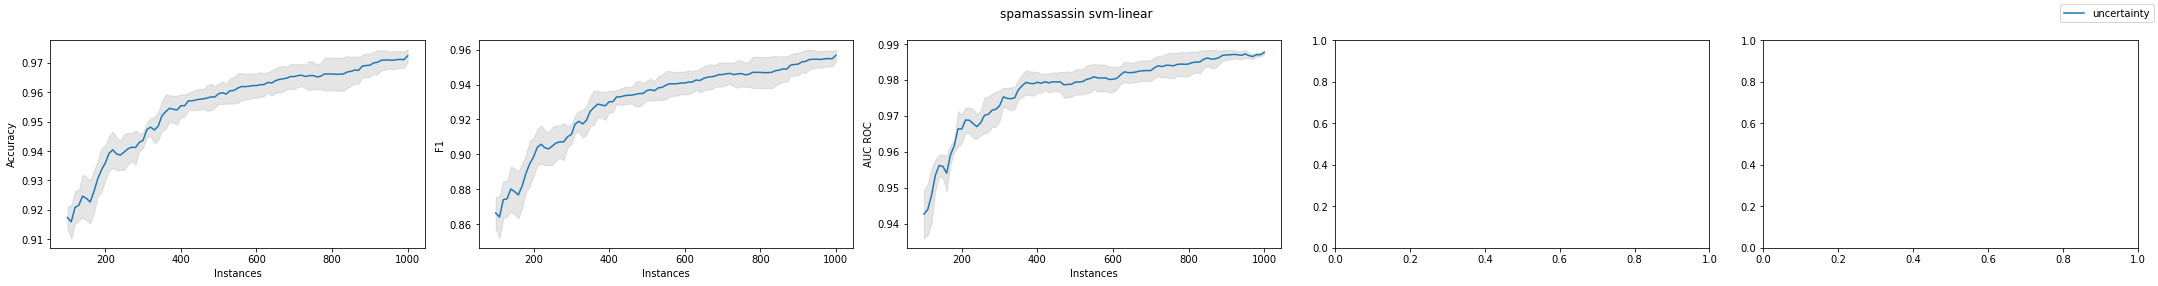

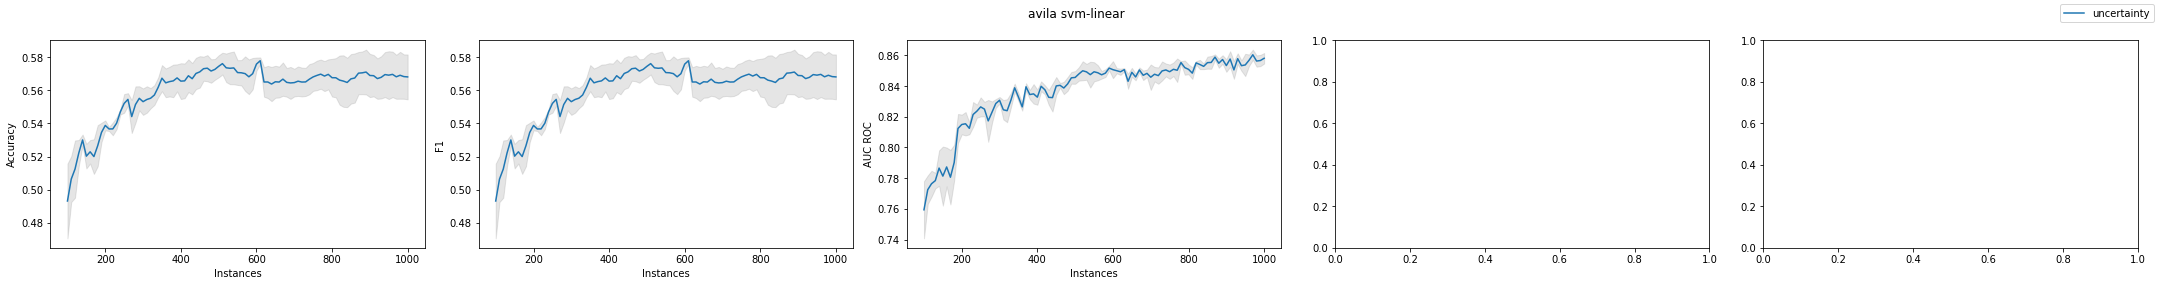

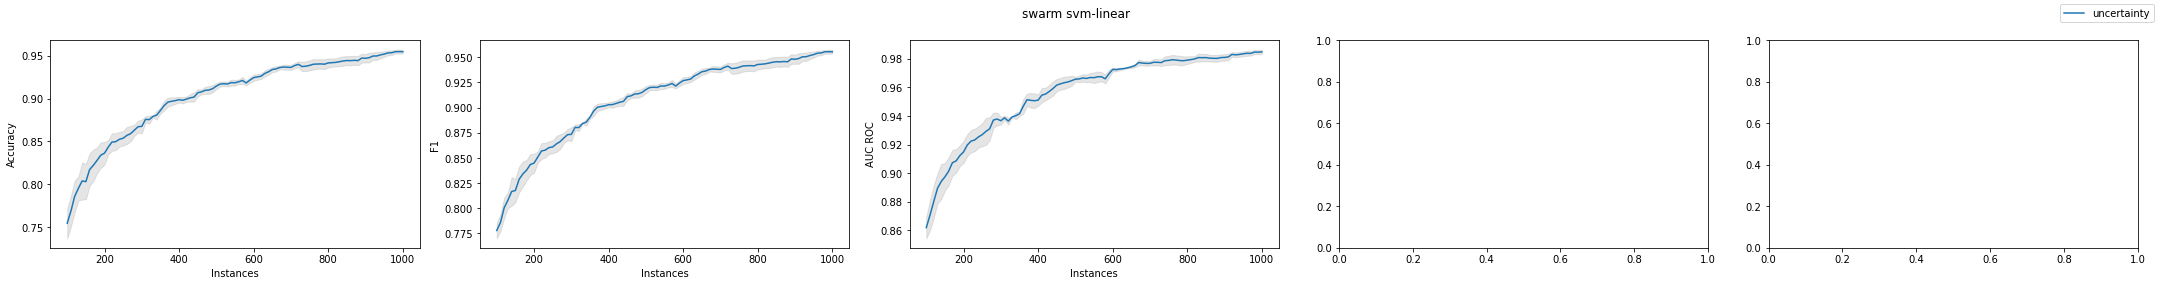

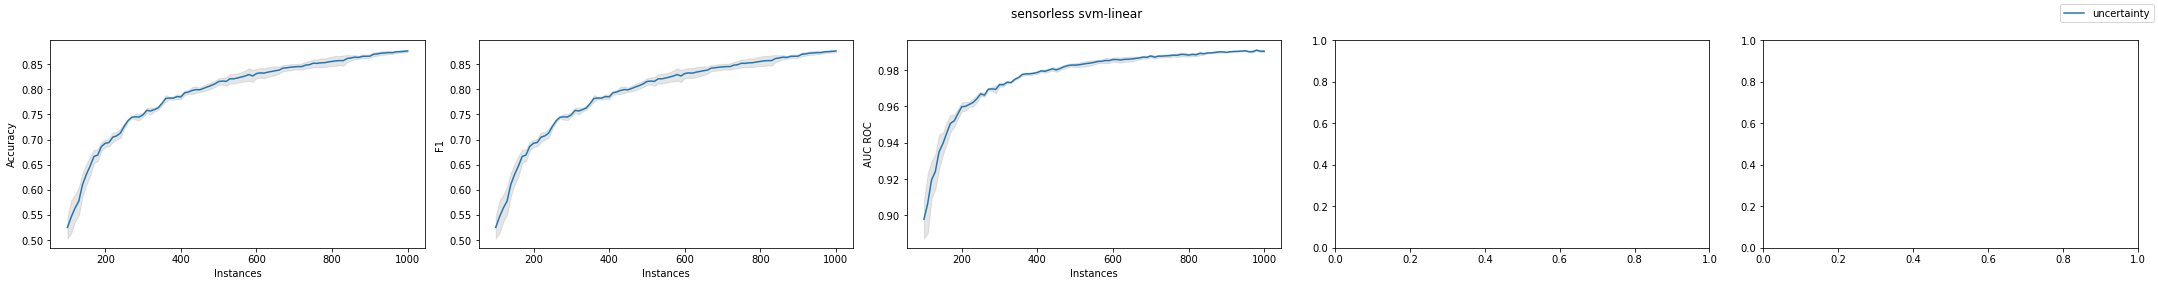

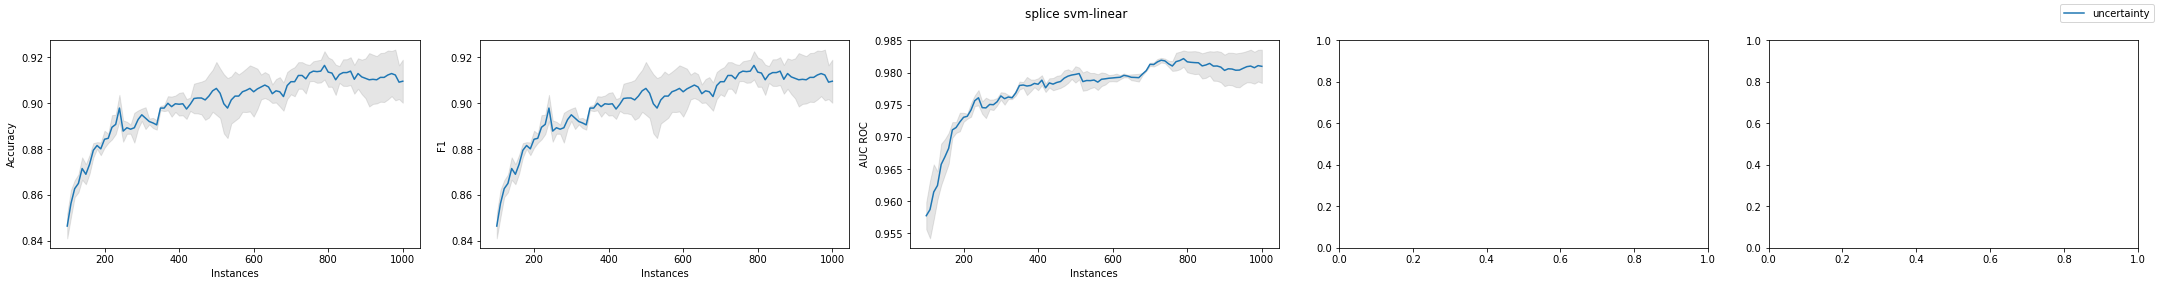

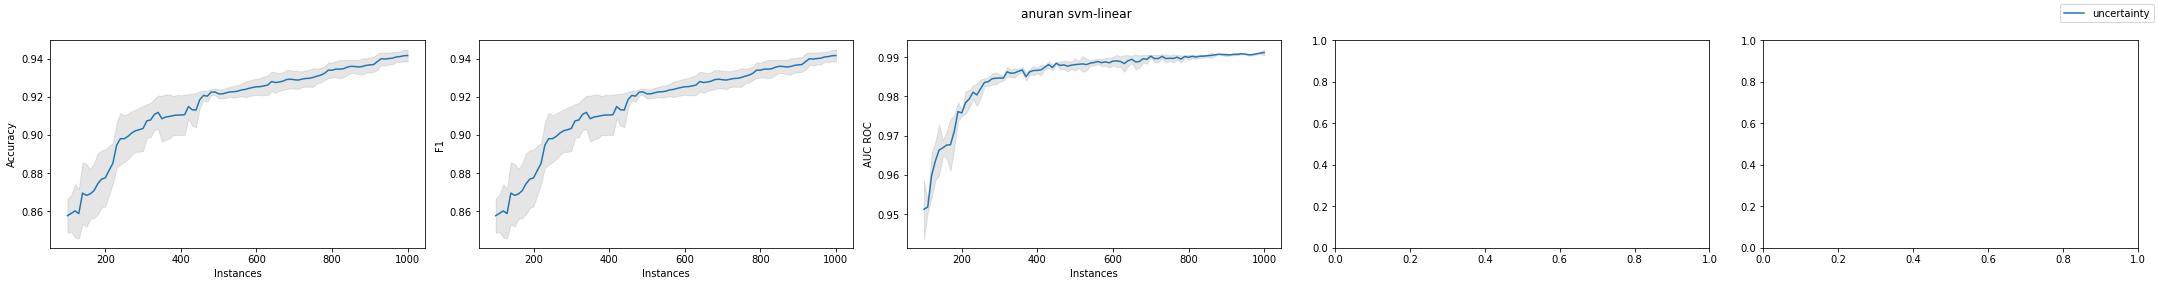

In [16]:
reload(librun)
librun.plot_stop(results_plots, classifiers, stop_conditions, stop_results, figsize=(30, 4))